## Notebook used to forecast using classical machine learning

In [2]:
# python standard libraries
from datetime import datetime
import time
import sys

# data processing
import pandas as pd
import numpy as np
from tqdm import tqdm

# plotting
from pandas.plotting import scatter_matrix
from matplotlib import cm
import seaborn as sns
import matplotlib.patches as mpatches
import pylab as plot
import matplotlib.pyplot as plt

# normalize
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV

# ml models
# error based models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

# information based models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# similarity based
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier

# scoring metrics
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# ignore warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-x8wi_z2m because the default path (/home/plarosa/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [366]:
class AutoML(object):
    def __init__(self, model_code):
        self.splits = []
        models = {
            # regressor
            # error based
            'lir' : [LinearRegression, 'Linear Regression'],
            'rdg' : [Ridge, 'Ridge Regression'],
            'lso' : [Lasso, 'Lasso Regression'],
            # information based
            'dtr' : [DecisionTreeRegressor, 'Decision Tree'], 
            'rfr' : [RandomForestRegressor, 'Random Forest'], 
            'gbr' : [GradientBoostingRegressor, 'GradientBoost'],
            
            'knr' : [KNeighborsRegressor, 'knn Regression'],

            # classifier
            # error based
            'log' : [LogisticRegression, 'Logistic Regression'],
            'svl' : [LinearSVC, 'Linear SVM'],
            'svm' : [SVC, 'SVM'],
            
            # information based
            'dtc' : [DecisionTreeClassifier, 'Decision Tree'],
            'rfc' : [RandomForestClassifier, 'Random Forest'],
            'gbc' : [GradientBoostingClassifier, 'Gradient Boost'], 
            # similarity based
            'knc' : [KNeighborsClassifier, 'knn Classification'],    
        }
        # multiple train
        self.summs = None
        self.test_model = None
        if isinstance(model_code, list):
            if all(map(lambda x:x in models, model_code)):
                self.model_code = model_code
                self.model = [models[i][0] for i in model_code]
                self.model_name = [models[i][1] for i in model_code]
            else:
                raise ValueError('invalid model_code!')
        else:
            if model_code not in models.keys():
                raise ValueError('invalid model_code!')
            self.model_code = model_code
            self.model = models[model_code][0]
            self.model_name = models[model_code][1]
        # used only for appending for model_name
        self.append = True
        
    def split_data(self, X, y, random_state=1337, shuffle=True, 
                   method='train_test', num_trials=1, stratify=False, **kwargs):
        stratify_dict = {}
        if self.splits:
            return self.splits
        
        if method == 'train_test':
            if stratify:
                stratify_dict['stratify'] = y
                
            for i in range(num_trials):
                test_size = 0.2 if 'test_size' not in kwargs.keys() else kwargs['test_size']

                X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                                    test_size=test_size,
                                                                    random_state=i, 
                                                                    shuffle=shuffle,
                                                                    **stratify_dict)
                
                self.splits.append((X_train, X_test, y_train, y_test))
        elif method == 'kfold':
            n_splits = 8 if 'n_splits' not in kwargs.keys() else kwargs['n_splits']
            if stratify:
                kf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
                self.splits = [(X.iloc[i], X.iloc[j], y.iloc[i], y.iloc[j]) for (i, j) in kf.split(X, y)]
            else:
                kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
                self.splits = [(X.iloc[i], X.iloc[j], y.iloc[i], y.iloc[j]) for (i, j) in kf.split(X)]

        return self.splits
    
    def generate_summary(self,):
        if self.summs is not None:
            return self.summs
        return [self.model_name, self.test_score, self.best_param, 
                self.top_predictor, self.run_time]
    
    def plot_feature_importance(self, absol=True, sort=True):
        fig, ax = plt.subplots(figsize=(6,8))
        mean_coefs = self.mean_coefs.copy()
        feature_names = self.feature_names.copy()

        if absol:
            mean_coefs = np.abs(mean_coefs)
        
        if sort:
            feature_names = feature_names[np.argsort(np.abs(mean_coefs))]
            mean_coefs = sorted(np.abs(mean_coefs))
        ax.set_title(self.model_name)
        ax.barh(np.arange(self.coefs_count), mean_coefs)
        ax.set_yticks(np.arange(self.coefs_count))
        ax.set_yticklabels(feature_names)
    
    def plot_train_val(self, log_scale=False):
        # Initialize figure
        fig, ax = plt.subplots(figsize=(15, 6))
        plt.title(self.model_name, fontsize=16)
        values = [list(param.values())[0] for param in self.param_grid]
        
        if log_scale:
            plt.xscale('log')
            
        # Plot the spread of predictions
        ax.fill_between(
            values,
            np.mean(self.score_train, axis=0) + np.std(self.score_train, axis=0),
            np.mean(self.score_train, axis=0) - np.std(self.score_train, axis=0),
            color='tab:blue', alpha=0.10
        )
        ax.fill_between(
            values,
            np.mean(self.score_test, axis=0) + np.std(self.score_test, axis=0),
            np.mean(self.score_test, axis=0) - np.std(self.score_test, axis=0),
            color='tab:orange', alpha=0.10
        )
        # Plot mean of the predictions
        ax.plot(values, np.mean(self.score_train, axis=0), lw=3,
                label="training accuracy")
        ax.plot(values, np.mean(self.score_test, axis=0), lw=3,
                label="validation accuracy")
        
        plt.xlabel(list(self.param_grid[0].keys())[0])
        plt.legend()
        plt.ylabel('accuracy')
        
    def set_model_default_params(self, model):
        default_params = {
            'rfr' : {'n_jobs' : -1, 'n_estimators':50}, 
            'rfc' : {'n_jobs' : -1, 'n_estimators':50}, 
            'gbr' : {'n_estimators':50},
            'gbc' : {'n_estimators':50}
        }
        
        if self.model_code in default_params.keys():
            model.set_params(**default_params[self.model_code])
        
        elif self.model_code == 'log':
            if 'penalty' in self.fixed_params.keys() and self.fixed_params['penalty'] == 'l1':
                default_params = {'solver' : 'liblinear'}
            else:
                default_params = {'dual' : False}
        
            model.set_params(**default_params)
            if self.append:
                self.model_name = f'{self.model_name} ({self.fixed_params["penalty"]})'  
                self.append = False
        
        elif self.model_code == 'svl':
            if 'penalty' in self.fixed_params.keys() and self.fixed_params['penalty'] == 'l1':
                default_params = {'loss' : 'squared_hinge', 'dual' : False}
                model.set_params(**default_params)
            if self.append:
                self.model_name = f'{self.model_name} ({self.fixed_params["penalty"]})'  
                self.append = False
        
        return model
    
    def get_coefs(self, reg):
        if self.model_code in ['dtr', 'dtc', 
                               'rfr', 'rfc', 
                               'gbr', 'gbc']:
            coefs = reg.feature_importances_
        elif self.model_code in ['lir', 'rdg', 'lso', 'log', 'svl']:
            coefs = reg.coef_
        elif self.model_code in ['knr', 'knc']:
            coefs = None

        return coefs
    
    def train_model(self, X, y,
                    random_state=0, fixed_params={}, 
                    param_grid={'max_depth':range(2,11)}, 
                    normalize=False, plot_train_val=True, 
                    plot_feat_imp=True):
        if isinstance(self.model_code, list):
            self.train_models_multiple(X, y,
                    random_state, fixed_params, 
                    param_grid, 
                    normalize, plot_train_val, 
                    plot_feat_imp)
            return 
        
        start_time = time.time()
        score_train = []
        score_test = []
        weighted_coefs=[]
        param_grid = list(ParameterGrid(param_grid))
        model = self.model
        self.fixed_params = fixed_params
        self.normalize = normalize
        
        with tqdm(total=len(self.splits), file=sys.stdout, 
                  position=0, leave=True) as pbar:
            for split in self.splits:
                pbar.set_description(self.model_name)
                
                training_accuracy = []  
                test_accuracy = []
                X_train, X_test, y_train, y_test = split

                if normalize: 
                    # normalize the features
                    Scaler = normalize().fit(X_train)
                    X_train = Scaler.transform(X_train)
                    X_test = Scaler.transform(X_test)
                    
                if self.model_code in ['lir']:
                    mdl = model()
                    mdl.fit(X_train, y_train)
                    y_pred_train = mdl.predict(X_train)
                    training_accuracy.append(mean_absolute_error(y_pred_train, y_train))
                    y_pred_test = mdl.predict(X_test)
                    test_accuracy.append(mean_absolute_error(y_pred_test, y_test))
                    coefs = self.get_coefs(mdl)
                    weighted_coefs.append(coefs)
                else:
                    for param in param_grid:
                        try:
                            mdl = model(random_state=random_state, 
                                         **param)
                        except TypeError:
                            mdl = model(**param)

                        mdl = self.set_model_default_params(mdl)
                        try:
                            mdl.set_params(**fixed_params)
                        except KeyError:
                            pass

                        mdl.fit(X_train, y_train)
                        y_pred_train = mdl.predict(X_train)
                        training_accuracy.append(mean_absolute_error(y_pred_train, y_train))
                        y_pred_test = mdl.predict(X_test)
                        test_accuracy.append(mean_absolute_error(y_pred_test, y_test))
                        coefs = self.get_coefs(mdl)
                        weighted_coefs.append(coefs)
                pbar.update(1)

                score_train.append(training_accuracy)
                score_test.append(test_accuracy)

        # get the mean of the weighted coefficients over all the trials  
        mean_coefs = None if self.model_code in ['knr', 'knc'] else np.mean(weighted_coefs, axis=0)
        mean_coefs = (None if self.model_code in ['knr', 'knc'] 
                      else (mean_coefs if mean_coefs.ndim == 1 else mean_coefs.mean(axis=0)))
        score = np.mean(score_test, axis=0)
        top_predictor = 'NA' if self.model_code in ['knr', 'knc'] else X.columns[np.argmax(np.abs(mean_coefs))]
        
        # for plotting train and test accuracy
        self.score_train = score_train
        self.score_test = score_test
        self.param_grid = param_grid
        
        # for plotting feature importance
        self.mean_coefs = None if self.model_code in ['knr', 'knc'] else mean_coefs
        self.coefs_count = None if self.model_code in ['knr', 'knc'] else len(self.mean_coefs) 
        self.feature_names = X.columns
        
        # for summary
        self.test_score = np.amin(score)
        best_param = [f'{key} =  {value}' 
                      for key, value in param_grid[np.argmin(score)].items()]
        self.best_param = ';'.join(best_param) if self.model_code != 'lir' else 'NA'
        self.top_predictor = top_predictor
        self.run_time = (time.time() - start_time)
        
        # for score
        self.test_param = param_grid[np.argmin(score)]
        
        if plot_train_val:
            if self.model_code == 'lir':
                pass
            elif self.model_code not in ['log', 'svl']:
                self.plot_train_val()
            else:
                self.plot_train_val(log_scale=True)
        
        if plot_feat_imp:
            if self.model_code not in ['knr', 'knc']:
                self.plot_feature_importance()
    
    def train_models_multiple(self, X, y,
                              random_state=0, fixed_params={}, 
                              param_grid={'max_depth':range(2,11)}, 
                              normalize=False, plot_train_val=True, 
                              plot_feat_imp=True):
        """should have the same params"""
        model_codes = self.model_code
        models = self.model
        model_names = self.model_name
        summs = []
        for model_code, model, model_name in zip(model_codes, models, model_names):
            self.append = True
            self.model_code = model_code
            self.model = model
            self.model_name = model_name
            self.train_model(X, y, random_state, fixed_params, 
                            param_grid, 
                            normalize, plot_train_val, 
                            plot_feat_imp)
            summs.append(self.generate_summary())
            
        
        summs = pd.DataFrame(summs)
        summs.columns = ['Machine Learning Method', 'Test Accuracy', 
                         'Best Parameter', 'Top Predictor Variable', 'Run Time']
        
        self.summs = summs
    
    def score(self, X, y):
        """ Works for single model only"""
        if self.test_model is None:
            X_train, X_test, y_train, y_test = self.splits[0]
            
            if self.normalize: 
                # normalize the features
                Scaler = self.normalize().fit(X_train)
                X_train = Scaler.transform(X_train)
                X_test = Scaler.transform(X_test)
                self.test_scaler = Scaler
            
            test_model = self.model()
            test_model = self.set_model_default_params(test_model)
            try:
                test_model.set_params(**self.fixed_params)
            except KeyError:
                pass

            test_model.set_params(**self.test_param)
            test_model.fit(X_train, y_train)
            self.test_model = test_model
        
        if self.normalize:
            X = self.test_scaler.transform(X)
        
        return self.test_model.score(X, y)
        

In [4]:
df_full = pd.read_csv('data/tesla_complete')

In [368]:
X = df_full.drop(['target', 'Date'], axis=1)
y = df_full.loc[:, 'target']

knn Classification: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable,Run Time
0,Decision Tree,0.492748,max_depth = 4,%D,1.083670
1,Random Forest,0.491603,max_depth = 8,%D,30.195312
2,Gradient Boost,0.490840,max_depth = 1,%D,32.566589
3,Logistic Regression (l1),0.491985,C = 10,High,37.469027
4,Linear SVM (l1),0.492748,C = 0.01,High,2.871052
5,Logistic Regression (l2),0.491412,C = 100,High,3.718392
6,Linear SVM (l2),0.493511,C = 10,High,4.373049
7,knn Classification,0.509160,n_neighbors = 2,NA,6.043351


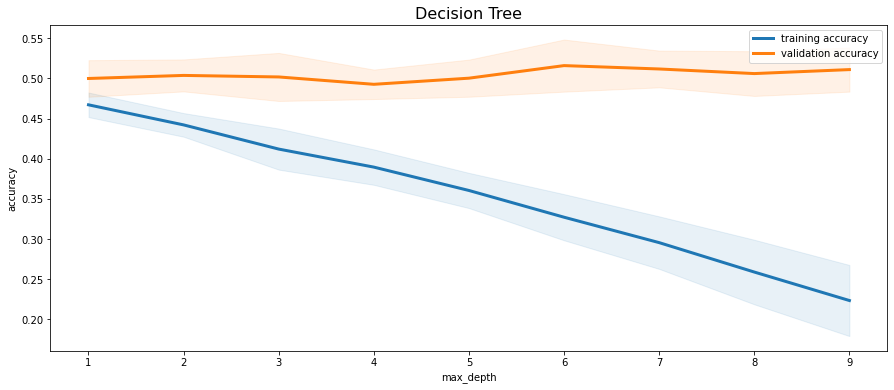

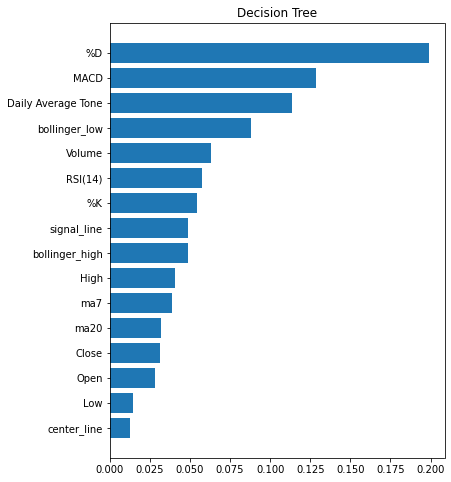

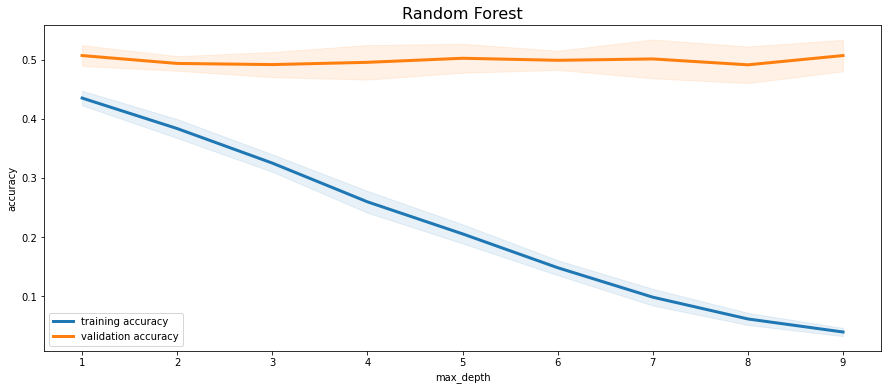

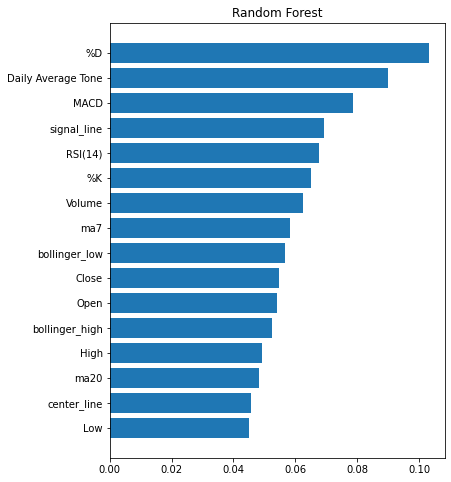

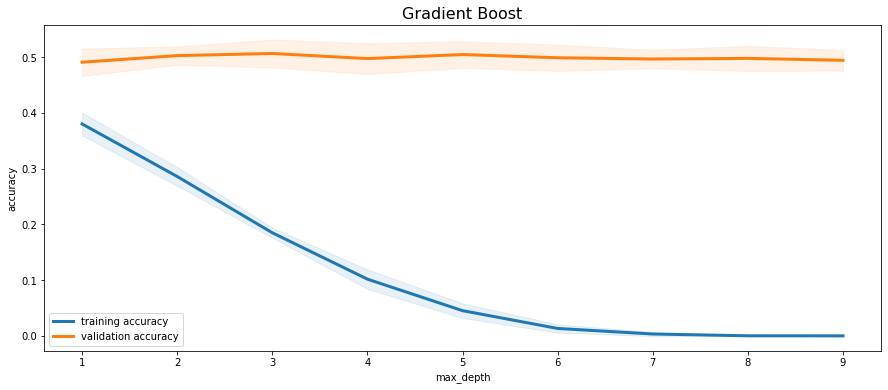

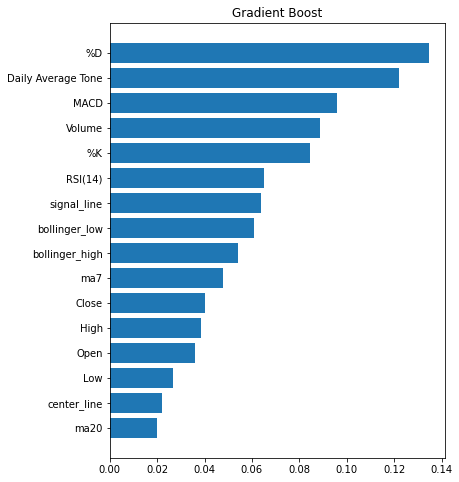

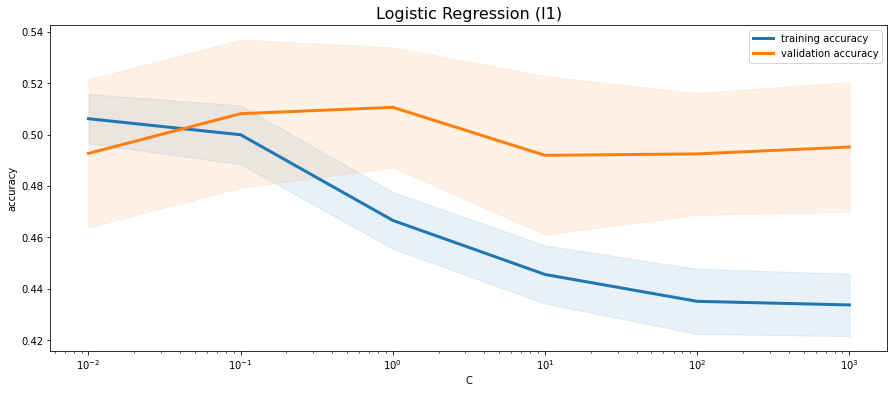

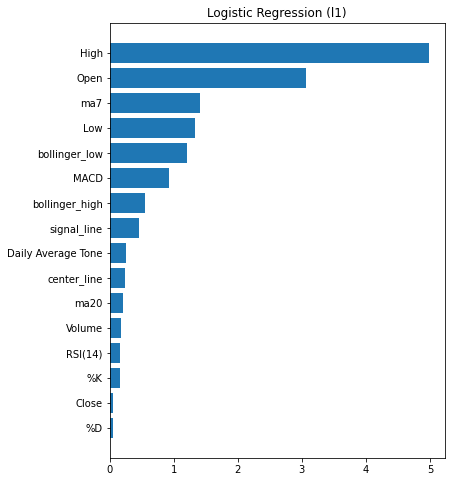

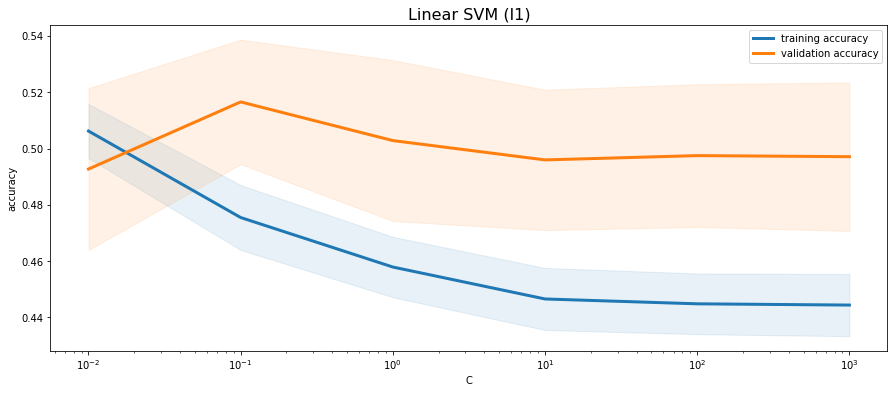

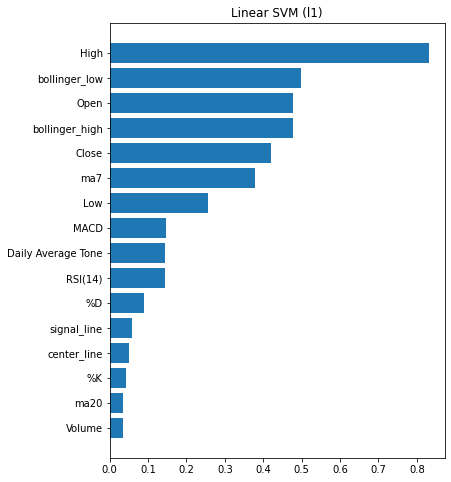

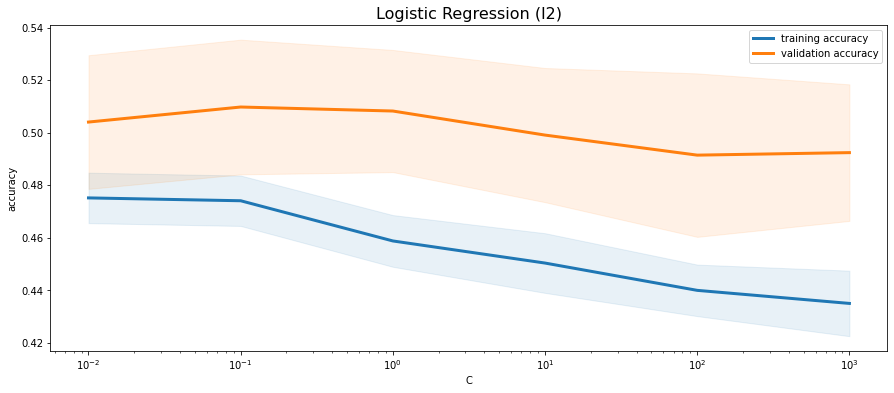

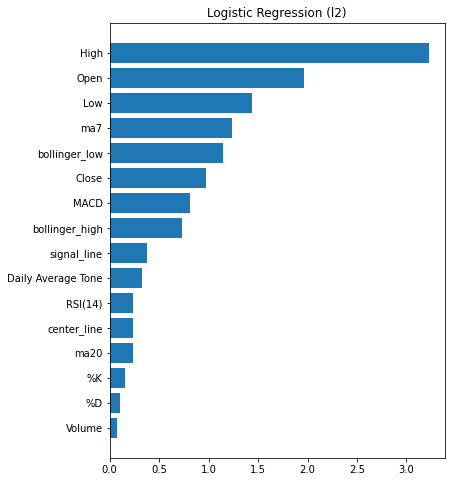

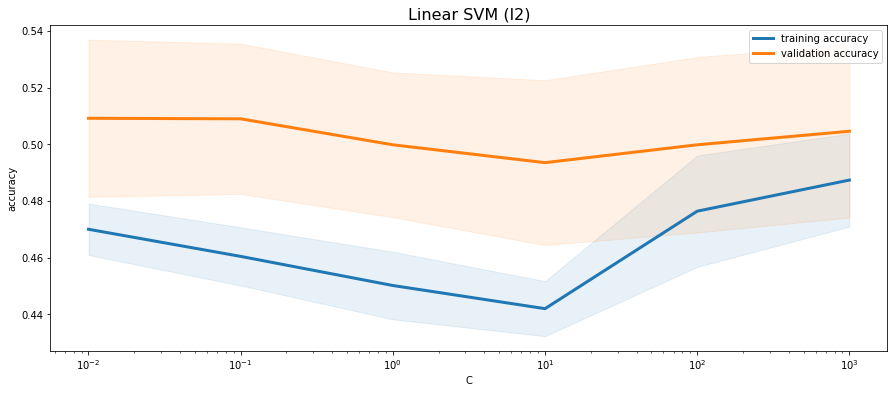

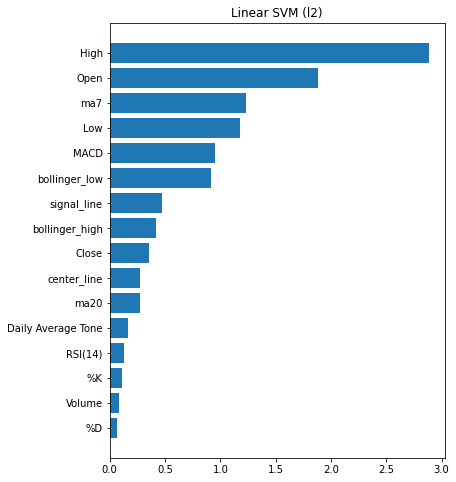

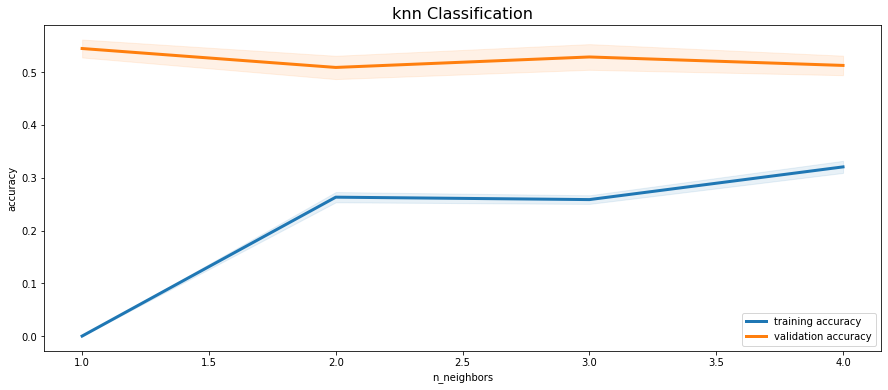

In [369]:
C = [.01, 0.1, 1, 10, 100, 1000]
n_neighbors = list(range(1, 51))
max_depth = list(range(1, 10))

automl_tree = AutoML(['dtc', 'rfc', 'gbc'])
splits = automl_tree.split_data(X, y, shuffle=True, num_trials=10, test_size=0.25)
automl_tree.train_model(X, y, param_grid={'max_depth':max_depth})
tree_summary = automl_tree.generate_summary()

automl_linear_l1 = AutoML(['log', 'svl'])
splits = automl_linear_l1.split_data(X, y, shuffle=True, num_trials=20, test_size=0.25)
automl_linear_l1.train_model(X, y, param_grid= {'C' : C}, 
                        fixed_params={'penalty' : 'l1'}, normalize=MinMaxScaler)
linearl1_summary = automl_linear_l1.generate_summary()

automl_linear_l2 = AutoML(['log', 'svl'])
splits = automl_linear_l2.split_data(X, y, shuffle=True, num_trials=20, test_size=0.25)
automl_linear_l2.train_model(X, y, param_grid= {'C' : C}, 
                        fixed_params={'penalty' : 'l2'}, normalize=MinMaxScaler)
linearl2_summary = automl_linear_l2.generate_summary()

automl_knc = AutoML('knc')
splits = automl_knc.split_data(X, y, num_trials=5, test_size=0.25, 
                               shuffle=True)
automl_knc.train_model(X, y, param_grid={'n_neighbors' : range(1,5)},
                               normalize=MinMaxScaler)
knc_summary = automl_knc.generate_summary()


df_train1 = pd.concat([tree_summary, 
                linearl1_summary, 
                linearl2_summary]).reset_index(drop=True)
knc_summary = pd.Series(knc_summary, index=df_train1.columns)
df_train1.loc[len(df_train1)] = knc_summary
df_train1

In [370]:
df_test = pd.DataFrame()
df_test['Close_000'] = df_full['Close']
w = 7
h = 1
for lag in range(1,w+h):
    if len(str(lag)) < 3:
        pre_ = '0'*(3-len(str(lag)))
        lag_name = f'{pre_}{lag}'
    else:
        lag_name = str(lag)
    df_test[f'Close_{lag_name}'] = df_test['Close_000'].shift(lag)
    
df_test = df_test.dropna()
display(df_test)

,Close_000,Close_001,Close_002,Close_003,Close_004,Close_005,Close_006,Close_007
7,40.667999,41.438000,40.751999,40.821999,41.467999,43.422001,42.341999,40.891998
8,39.466000,40.667999,41.438000,40.751999,40.821999,41.467999,43.422001,42.341999
9,39.911999,39.466000,40.667999,41.438000,40.751999,40.821999,41.467999,43.422001
10,40.487999,39.911999,39.466000,40.667999,41.438000,40.751999,40.821999,41.467999
11,40.125999,40.487999,39.911999,39.466000,40.667999,41.438000,40.751999,40.821999
...,...,...,...,...,...,...,...,...
1041,55.212002,54.462002,54.639999,54.992001,53.556000,58.362000,57.175999,57.835999
1042,53.683998,55.212002,54.462002,54.639999,54.992001,53.556000,58.362000,57.175999
1043,53.540001,53.683998,55.212002,54.462002,54.639999,54.992001,53.556000,58.362000
1044,53.276001,53.540001,53.683998,55.212002,54.462002,54.639999,54.992001,53.556000


In [371]:
X = df_test.drop(['Close_000'], axis=1)
y = df_test.loc[:, 'Close_000']

knn Regression: 100%|██████████| 5/5 [00:00<00:00, 37.78it/s]


,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable,Run Time
0,Decision Tree,1.710270,max_depth = 4,Close_001,0.664448
1,Random Forest,1.653221,max_depth = 4,Close_001,25.752174
2,GradientBoost,1.660567,max_depth = 2,Close_001,15.039902
3,Lasso Regression,1.116811,alpha = 0.01,Close_001,0.118390
4,Ridge Regression,1.120333,alpha = 0.1,Close_001,0.597128


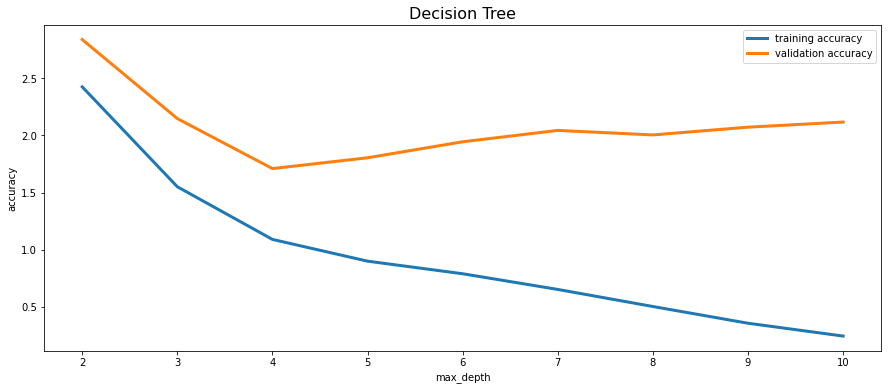

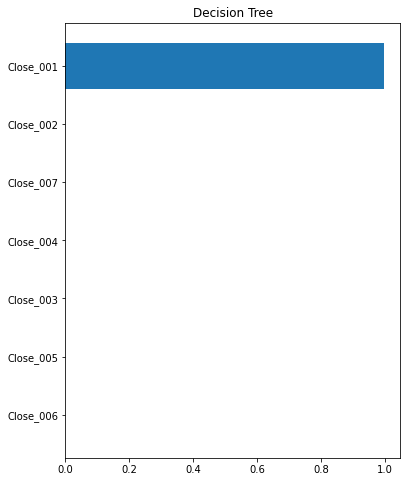

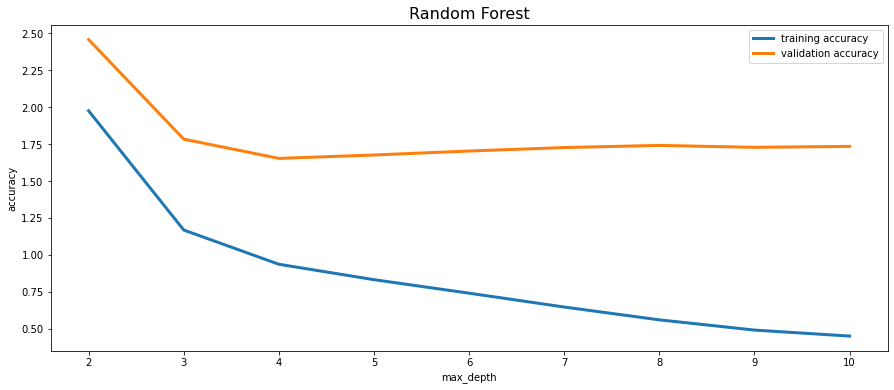

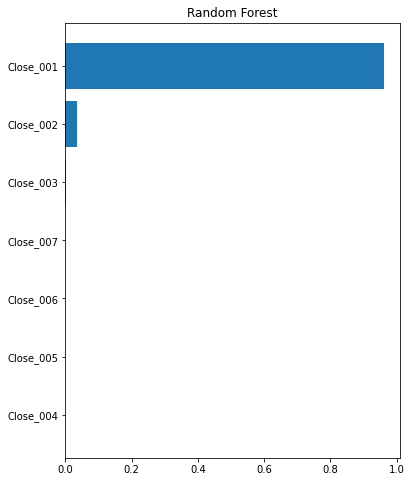

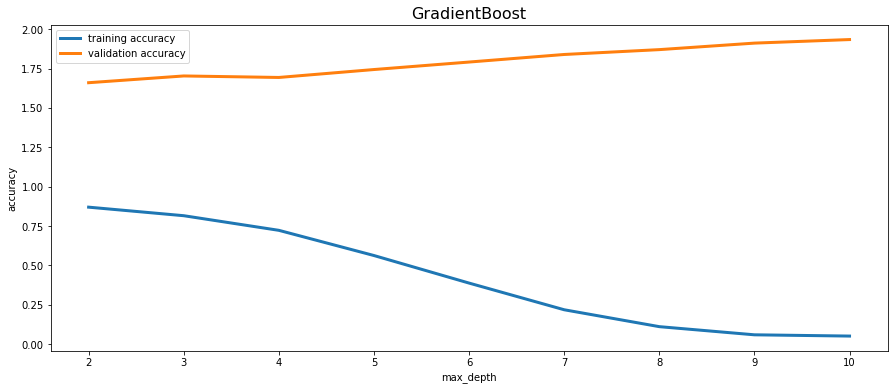

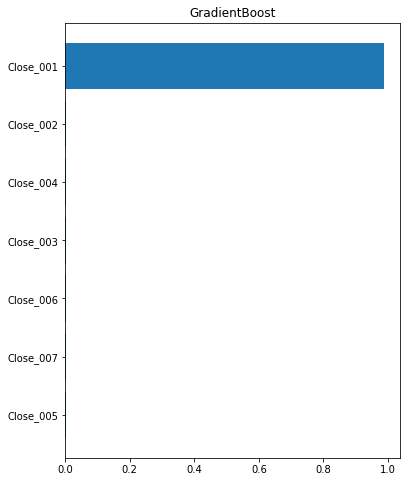

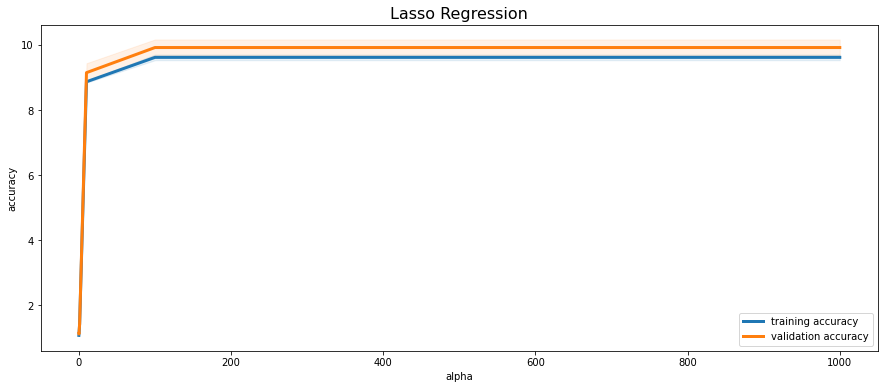

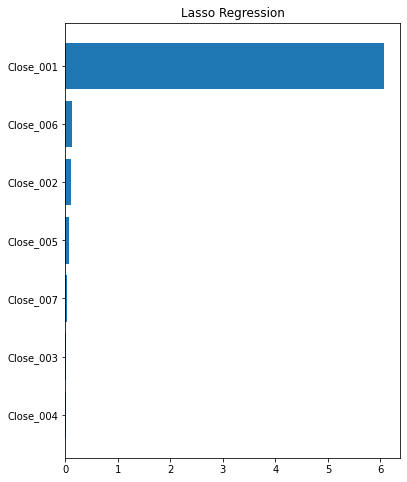

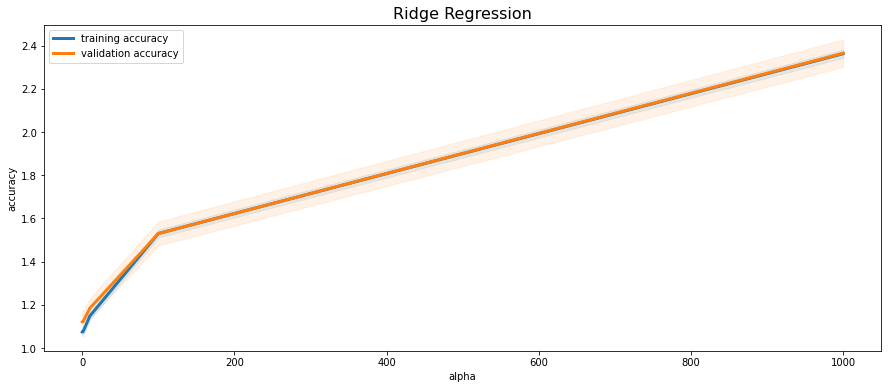

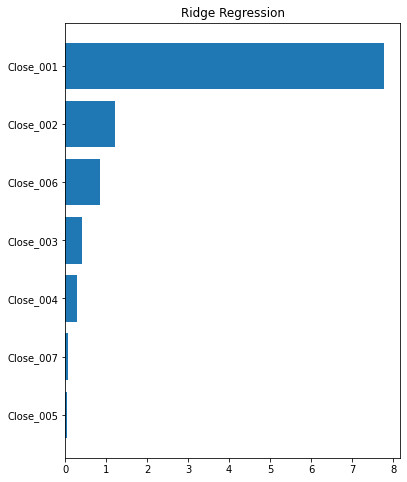

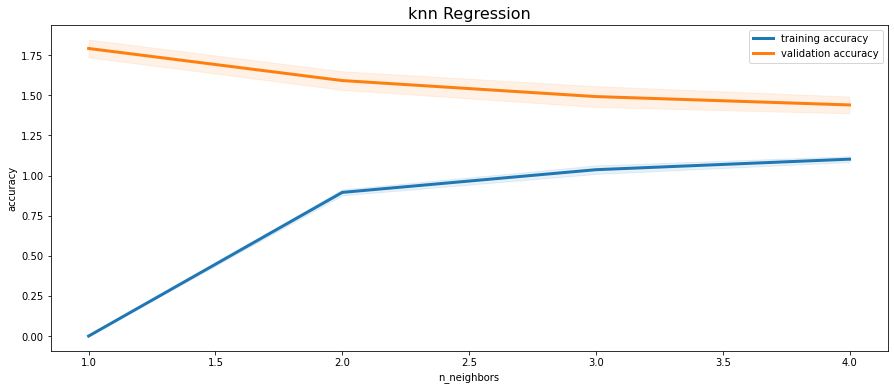

In [372]:
alpha = [1e-3, .01, 0.1,  1,  10, 100, 1000]
n_neighbors = list(range(1,50))
max_depth = list(range(1,10))

automl_tree = AutoML(['dtr', 'rfr', 'gbr'])
splits = automl_tree.split_data(X, y, shuffle=False, num_trials=10)
automl_tree.train_model(X, y)
tree_summary = automl_tree.generate_summary()

automl_linear = AutoML(['lso', 'rdg'])
splits = automl_linear.split_data(X, y, num_trials=5, test_size=0.25, 
                               shuffle=True)
automl_linear.train_model(X, y, param_grid={'alpha' : alpha},
                           normalize=StandardScaler)
linear_summary = automl_linear.generate_summary()

automl_knr = AutoML('knr')
splits = automl_knr.split_data(X, y, num_trials=5, test_size=0.25, 
                               shuffle=True)
automl_knr.train_model(X, y, param_grid={'n_neighbors' : range(1,5)},
                       normalize=StandardScaler)
knr_summary = automl_knr.generate_summary()


df = pd.concat([tree_summary, 
                linear_summary]).reset_index(drop=True)

df

In [373]:
df_test2 = df_test.copy()
df_test2['target'] = (df_test.loc[:, 'Close_000'] > 
                      df_test.loc[:, 'Close_001']) * 1

In [374]:
X = df_test2.drop(['Close_000', 'target'], axis=1)
y = df_test2.loc[:, 'target']

knn Classification: 100%|██████████| 5/5 [00:00<00:00,  8.21it/s]


,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable,Run Time
0,Decision Tree,0.497692,max_depth = 9,Close_007,0.644265
1,Random Forest,0.498077,max_depth = 7,Close_007,29.556095
2,Gradient Boost,0.478462,max_depth = 9,Close_007,19.068721
3,Logistic Regression (l1),0.489808,C = 1000,Close_006,6.799008
4,Linear SVM (l1),0.492115,C = 10,Close_006,1.565524
5,Logistic Regression (l2),0.489038,C = 10,Close_006,1.649101
6,Linear SVM (l2),0.490385,C = 10,Close_002,2.911171
7,knn Classification,0.490769,n_neighbors = 1,NA,0.611645


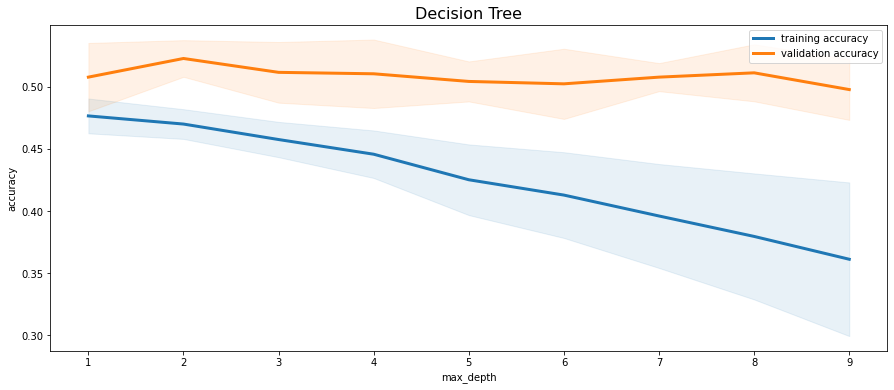

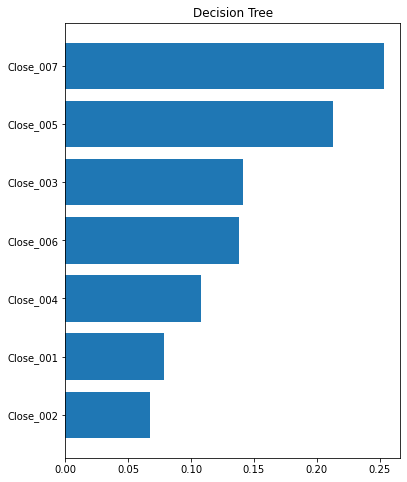

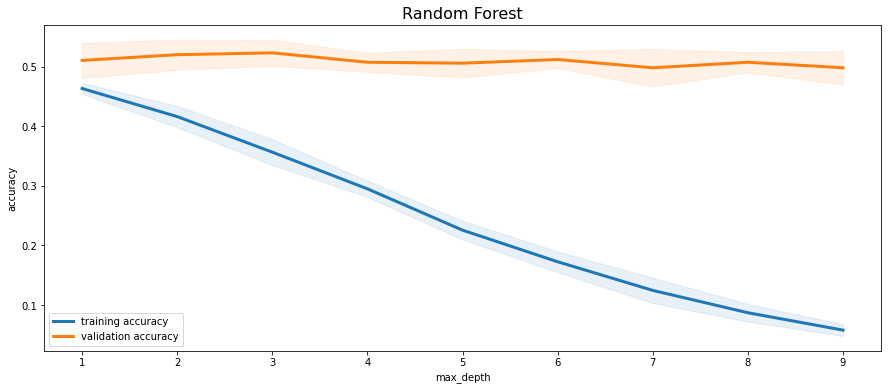

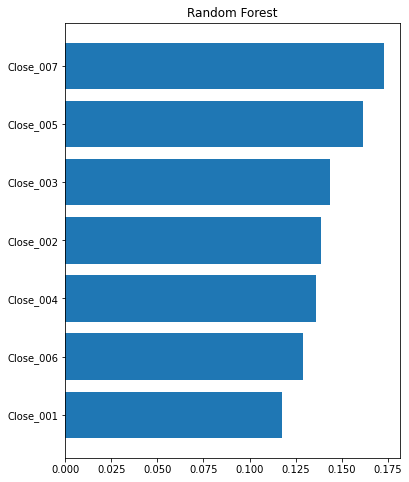

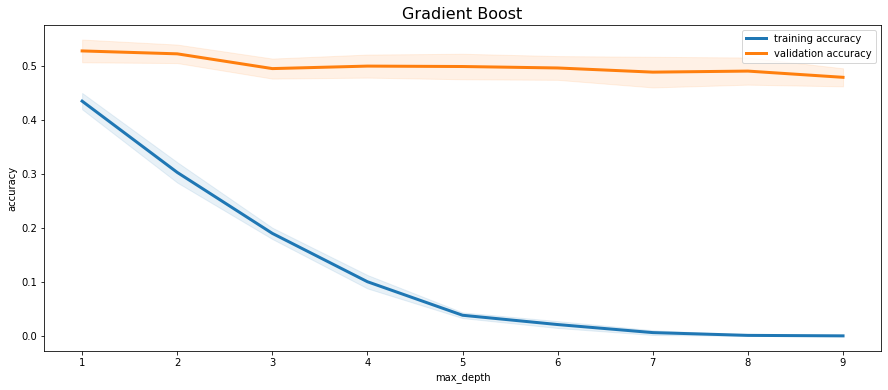

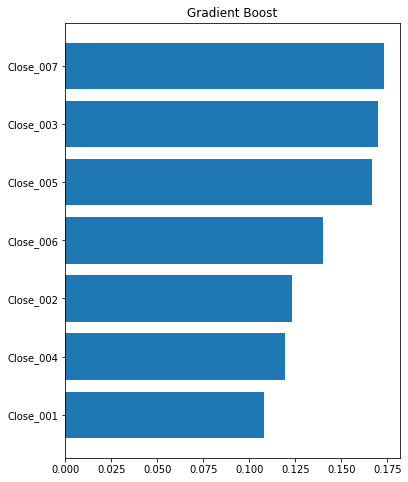

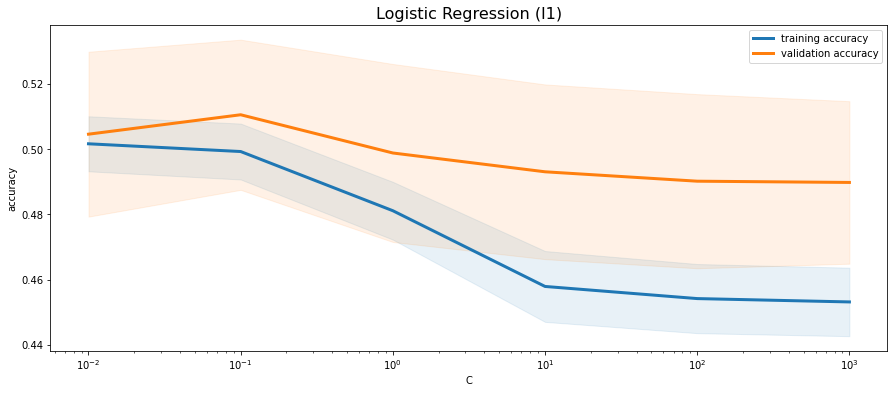

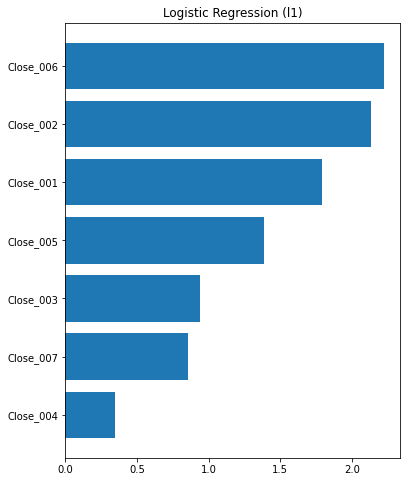

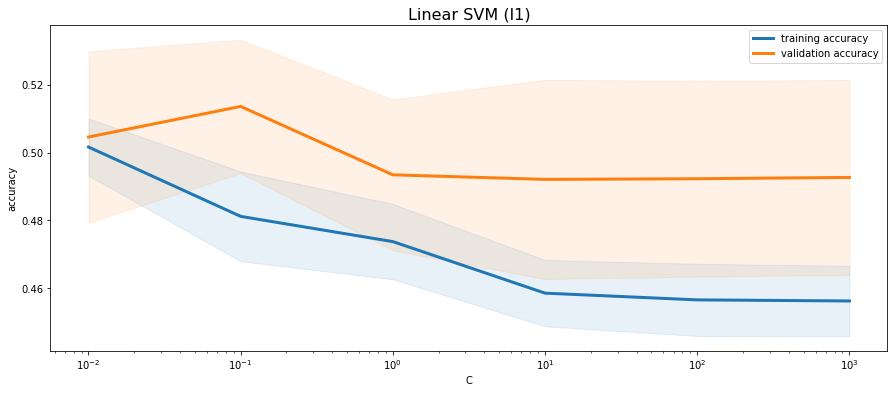

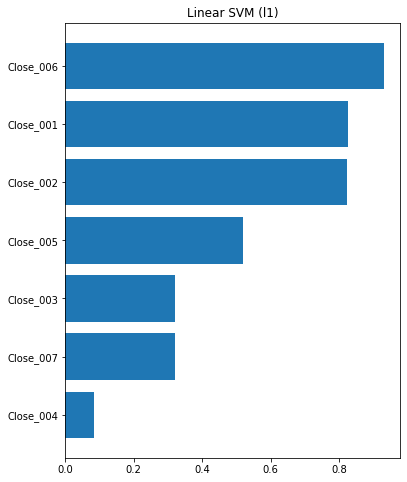

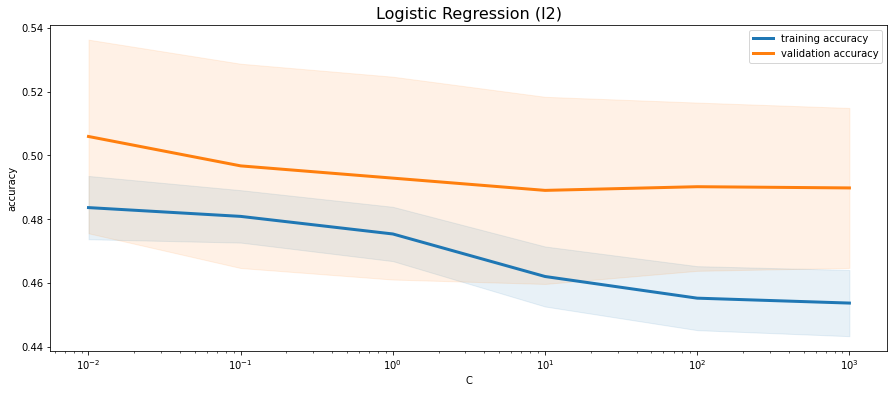

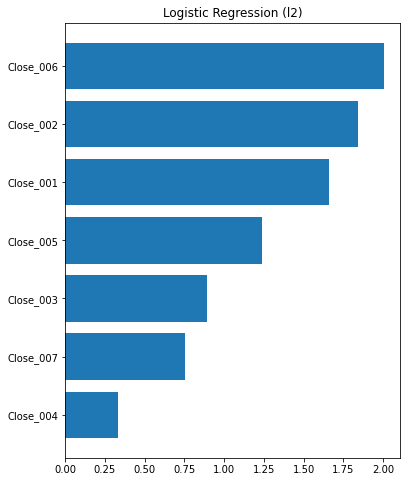

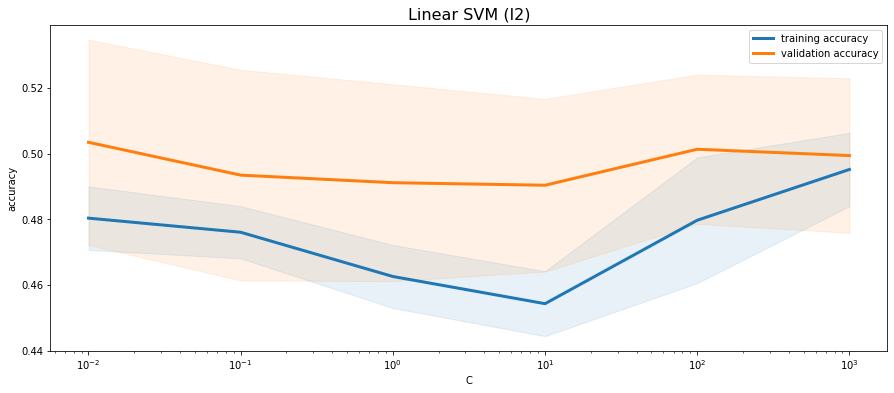

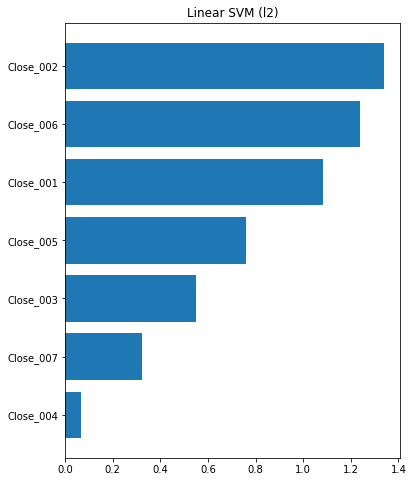

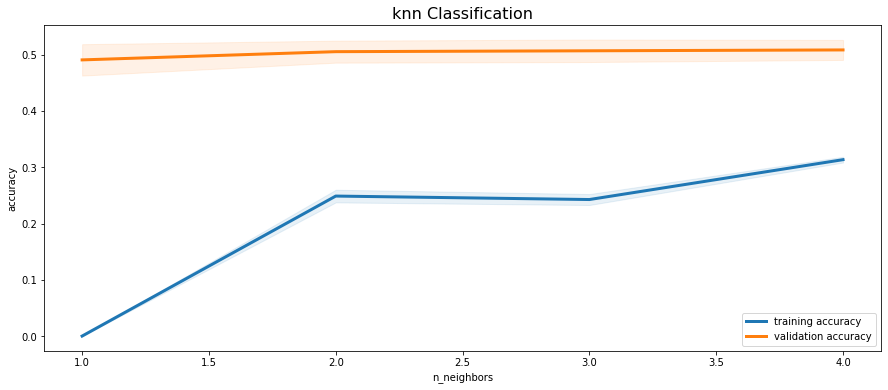

In [375]:
C = [.01, 0.1, 1, 10, 100, 1000]
n_neighbors = list(range(1, 51))
max_depth = list(range(1, 10))

automl_tree = AutoML(['dtc', 'rfc', 'gbc'])
splits = automl_tree.split_data(X, y, shuffle=True, 
                                num_trials=10, test_size=0.25)
automl_tree.train_model(X, y, param_grid={'max_depth':max_depth})
tree_summary = automl_tree.generate_summary()

automl_linear_l1 = AutoML(['log', 'svl'])
splits = automl_linear_l1.split_data(X, y, shuffle=True, num_trials=20, 
                                     test_size=0.25)
automl_linear_l1.train_model(X, y, param_grid= {'C' : C}, 
                        fixed_params={'penalty' : 'l1'}, 
                             normalize=MinMaxScaler)
linearl1_summary = automl_linear_l1.generate_summary()

automl_linear_l2 = AutoML(['log', 'svl'])
splits = automl_linear_l2.split_data(X, y, shuffle=True, 
                                     num_trials=20, test_size=0.25)
automl_linear_l2.train_model(X, y, param_grid= {'C' : C}, 
                        fixed_params={'penalty' : 'l2'}, 
                             normalize=MinMaxScaler)
linearl2_summary = automl_linear_l2.generate_summary()

automl_knc = AutoML('knc')
splits = automl_knc.split_data(X, y, num_trials=5, test_size=0.25, 
                               shuffle=True)
automl_knc.train_model(X, y, param_grid={'n_neighbors' : range(1,5)},
                               normalize=MinMaxScaler)
knc_summary = automl_knc.generate_summary()


df_train2 = pd.concat([tree_summary, 
                linearl1_summary, 
                linearl2_summary]).reset_index(drop=True)
knc_summary = pd.Series(knc_summary, index=df_train2.columns)
df_train2.loc[len(df_train2)] = knc_summary
df_train2

In [377]:
df_test = pd.DataFrame()
df_test['Close_000'] = df_full['Close']
df_test['Daily_Average_Tone_000'] = df_full['Daily Average Tone']
w = 7
h = 1
for lag in range(1,w+h):
    if len(str(lag)) < 3:
        pre_ = '0'*(3-len(str(lag)))
        lag_name = f'{pre_}{lag}'
    else:
        lag_name = str(lag)
    df_test[f'Close_{lag_name}'] = df_test['Close_000'].shift(lag)
    df_test[f'Daily_Average_Tone_{lag_name}'] = df_test['Daily_Average_Tone_000'].shift(lag)
    
df_test = df_test.dropna()
display(df_test)

,Close_000,Daily_Average_Tone_000,Close_001,Daily_Average_Tone_001,Close_002,Daily_Average_Tone_002,Close_003,Daily_Average_Tone_003,Close_004,Daily_Average_Tone_004,Close_005,Daily_Average_Tone_005,Close_006,Daily_Average_Tone_006,Close_007,Daily_Average_Tone_007
7,40.667999,0.062500,41.438000,0.625000,40.751999,1.823529,40.821999,1.162791,41.467999,0.181818,43.422001,0.021739,42.341999,0.350000,40.891998,4.000000
8,39.466000,2.000000,40.667999,0.062500,41.438000,0.625000,40.751999,1.823529,40.821999,1.162791,41.467999,0.181818,43.422001,0.021739,42.341999,0.350000
9,39.911999,-0.894737,39.466000,2.000000,40.667999,0.062500,41.438000,0.625000,40.751999,1.823529,40.821999,1.162791,41.467999,0.181818,43.422001,0.021739
10,40.487999,-0.681159,39.911999,-0.894737,39.466000,2.000000,40.667999,0.062500,41.438000,0.625000,40.751999,1.823529,40.821999,1.162791,41.467999,0.181818
11,40.125999,-0.136364,40.487999,-0.681159,39.911999,-0.894737,39.466000,2.000000,40.667999,0.062500,41.438000,0.625000,40.751999,1.823529,40.821999,1.162791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,55.212002,0.187500,54.462002,-0.486842,54.639999,-0.765432,54.992001,-1.768000,53.556000,-1.788889,58.362000,0.512821,57.175999,-2.030303,57.835999,-1.411765
1042,53.683998,-1.000000,55.212002,0.187500,54.462002,-0.486842,54.639999,-0.765432,54.992001,-1.768000,53.556000,-1.788889,58.362000,0.512821,57.175999,-2.030303
1043,53.540001,-0.137931,53.683998,-1.000000,55.212002,0.187500,54.462002,-0.486842,54.639999,-0.765432,54.992001,-1.768000,53.556000,-1.788889,58.362000,0.512821
1044,53.276001,-0.650000,53.540001,-0.137931,53.683998,-1.000000,55.212002,0.187500,54.462002,-0.486842,54.639999,-0.765432,54.992001,-1.768000,53.556000,-1.788889


In [378]:
X = df_test.drop(['Close_000', 'Daily_Average_Tone_000'], axis=1)
y = df_test.loc[:, 'Close_000']

knn Regression: 100%|██████████| 5/5 [00:00<00:00, 14.02it/s]


,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable,Run Time
0,Decision Tree,1.710270,max_depth = 4,Close_001,0.813306
1,Random Forest,1.653413,max_depth = 4,Close_001,22.914597
2,GradientBoost,1.666546,max_depth = 2,Close_001,26.629528
3,Lasso Regression,1.119719,alpha = 0.1,Close_001,0.130598
4,Ridge Regression,1.131786,alpha = 1,Close_001,0.621893
5,knn Regression,2.182803,n_neighbors = 4,NA,0.359700


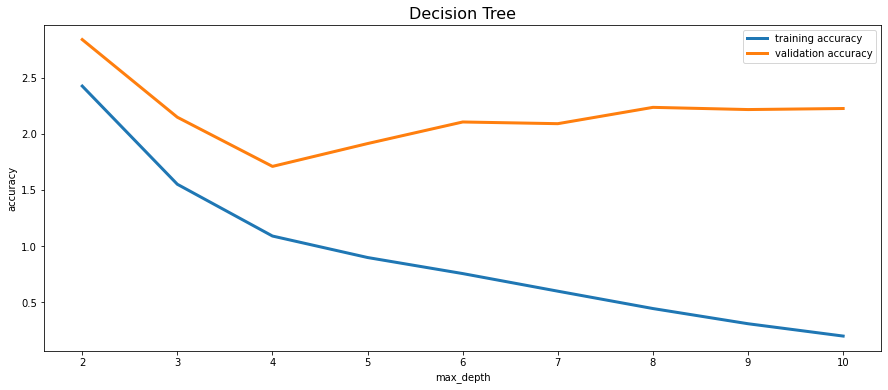

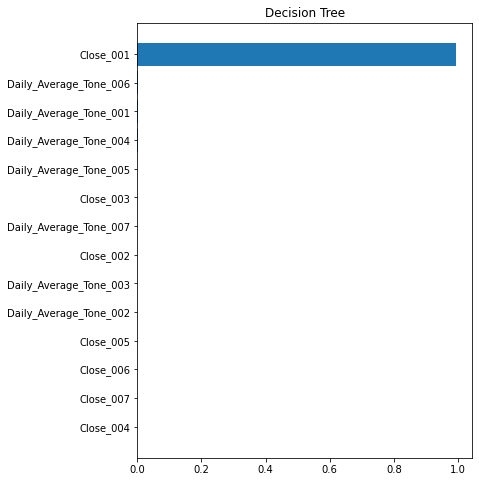

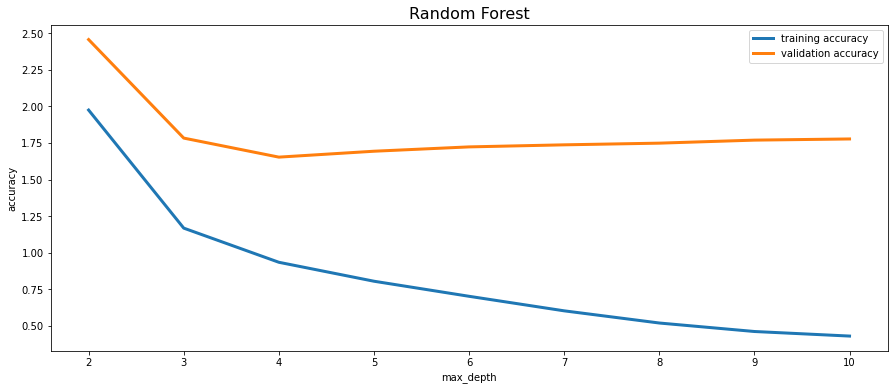

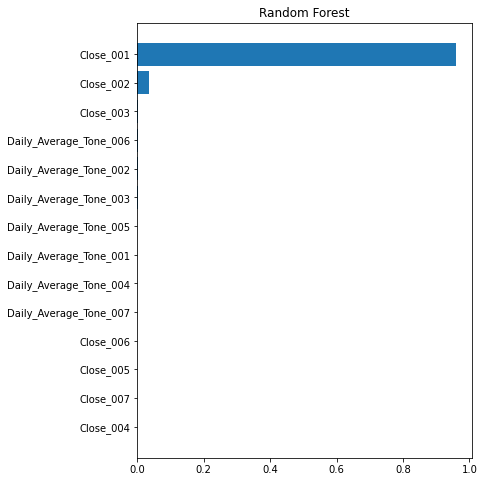

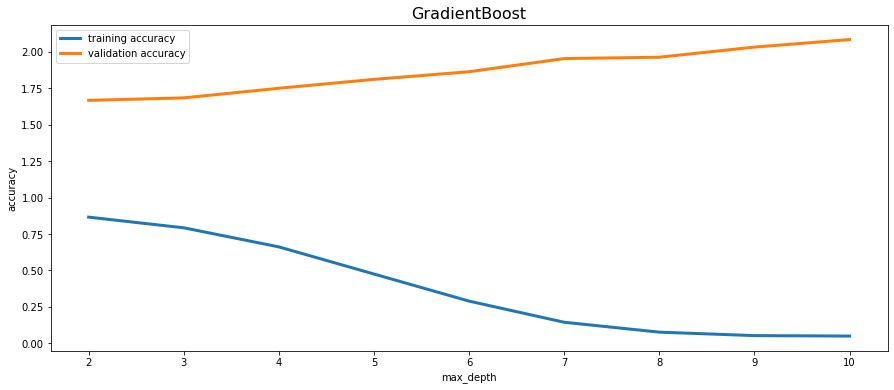

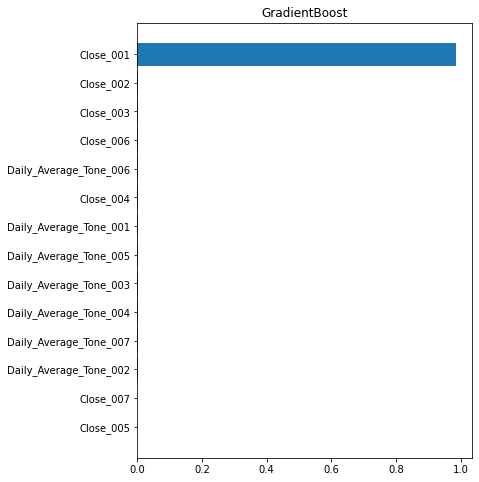

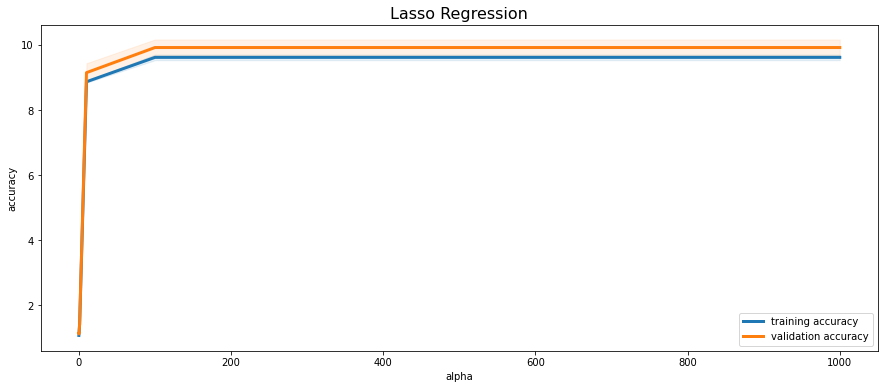

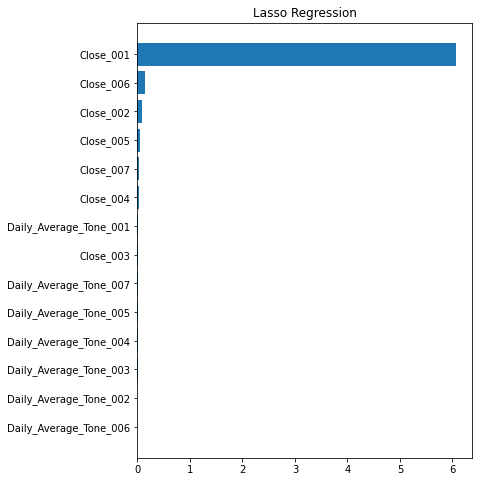

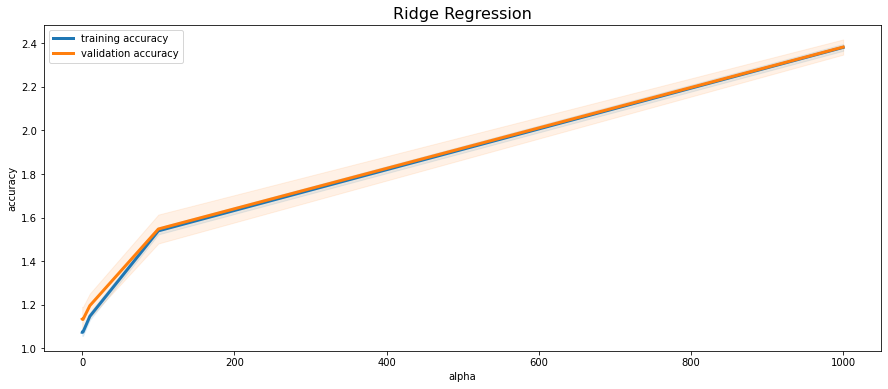

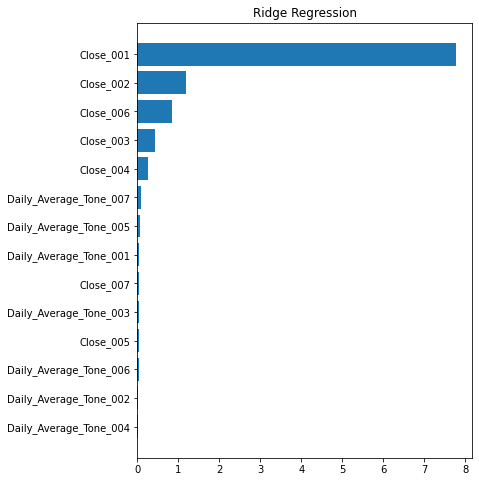

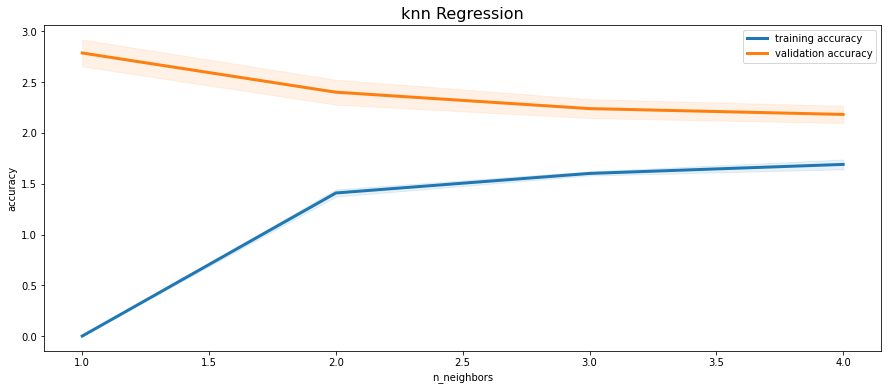

In [379]:
alpha = [1e-3, .01, 0.1,  1,  10, 100, 1000]
n_neighbors = list(range(1,50))
max_depth = list(range(1,10))

automl_tree = AutoML(['dtr', 'rfr', 'gbr'])
splits = automl_tree.split_data(X, y, shuffle=False, num_trials=10)
automl_tree.train_model(X, y)
tree_summary = automl_tree.generate_summary()

automl_linear = AutoML(['lso', 'rdg'])
splits = automl_linear.split_data(X, y, num_trials=5, test_size=0.25, 
                               shuffle=True)
automl_linear.train_model(X, y, param_grid={'alpha' : alpha},
                         normalize=StandardScaler)
linear_summary = automl_linear.generate_summary()

automl_knr = AutoML('knr')
splits = automl_knr.split_data(X, y, num_trials=5, test_size=0.25, 
                               shuffle=True)
automl_knr.train_model(X, y, param_grid={'n_neighbors' : range(1,5)},
                       normalize=StandardScaler)
knr_summary = automl_knr.generate_summary()


df = pd.concat([tree_summary, 
                linear_summary]).reset_index(drop=True)
knr_summary = pd.Series(knr_summary, index=df.columns)
df.loc[len(df)] = knr_summary
df

In [380]:
df_test2 = df_test.copy()
df_test2['target'] = (df_test.loc[:, 'Close_000'] > 
                      df_test.loc[:, 'Close_001']) * 1

X = df_test2.drop(['Close_000', 'Daily_Average_Tone_000', 'target'], axis=1)
y = df_test2.loc[:, 'target']

In [381]:
y.value_counts()

1    522
0    517
Name: target, dtype: int64

In [382]:
X

,Close_001,Daily_Average_Tone_001,Close_002,Daily_Average_Tone_002,Close_003,Daily_Average_Tone_003,Close_004,Daily_Average_Tone_004,Close_005,Daily_Average_Tone_005,Close_006,Daily_Average_Tone_006,Close_007,Daily_Average_Tone_007
7,41.438000,0.625000,40.751999,1.823529,40.821999,1.162791,41.467999,0.181818,43.422001,0.021739,42.341999,0.350000,40.891998,4.000000
8,40.667999,0.062500,41.438000,0.625000,40.751999,1.823529,40.821999,1.162791,41.467999,0.181818,43.422001,0.021739,42.341999,0.350000
9,39.466000,2.000000,40.667999,0.062500,41.438000,0.625000,40.751999,1.823529,40.821999,1.162791,41.467999,0.181818,43.422001,0.021739
10,39.911999,-0.894737,39.466000,2.000000,40.667999,0.062500,41.438000,0.625000,40.751999,1.823529,40.821999,1.162791,41.467999,0.181818
11,40.487999,-0.681159,39.911999,-0.894737,39.466000,2.000000,40.667999,0.062500,41.438000,0.625000,40.751999,1.823529,40.821999,1.162791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,54.462002,-0.486842,54.639999,-0.765432,54.992001,-1.768000,53.556000,-1.788889,58.362000,0.512821,57.175999,-2.030303,57.835999,-1.411765
1042,55.212002,0.187500,54.462002,-0.486842,54.639999,-0.765432,54.992001,-1.768000,53.556000,-1.788889,58.362000,0.512821,57.175999,-2.030303
1043,53.683998,-1.000000,55.212002,0.187500,54.462002,-0.486842,54.639999,-0.765432,54.992001,-1.768000,53.556000,-1.788889,58.362000,0.512821
1044,53.540001,-0.137931,53.683998,-1.000000,55.212002,0.187500,54.462002,-0.486842,54.639999,-0.765432,54.992001,-1.768000,53.556000,-1.788889


knn Classification: 100%|██████████| 5/5 [00:00<00:00,  6.66it/s]


,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable,Run Time
0,Decision Tree,0.508846,max_depth = 1,Close_007,0.894805
1,Random Forest,0.503846,max_depth = 8,Daily_Average_Tone_001,29.856197
2,Gradient Boost,0.500000,max_depth = 8,Daily_Average_Tone_001,29.944727
3,Logistic Regression (l1),0.495962,C = 100,Close_006,11.408991
4,Linear SVM (l1),0.497500,C = 1000,Close_006,2.808328
5,Logistic Regression (l2),0.496923,C = 100,Close_006,3.139380
6,Linear SVM (l2),0.498846,C = 10,Close_002,3.826491
7,knn Classification,0.490769,n_neighbors = 1,NA,0.753477


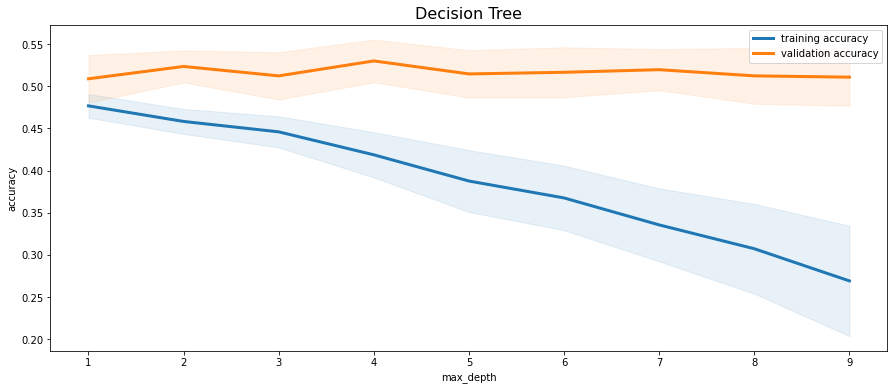

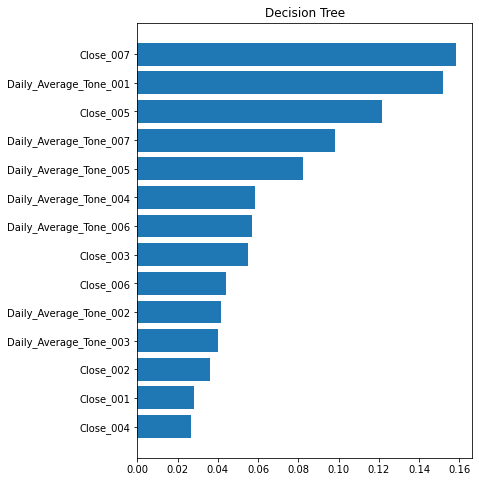

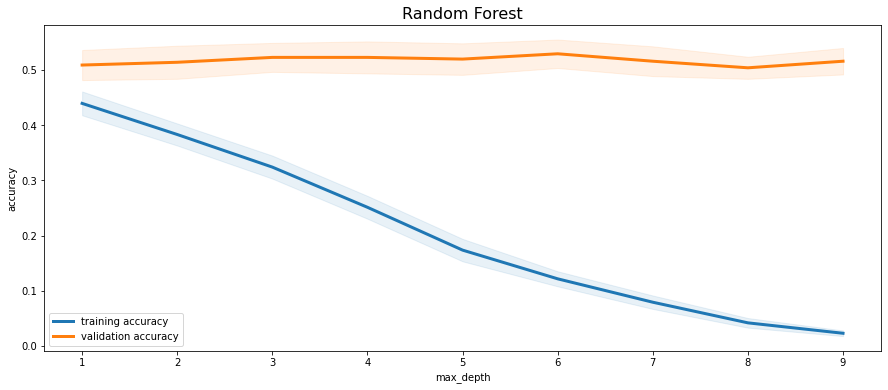

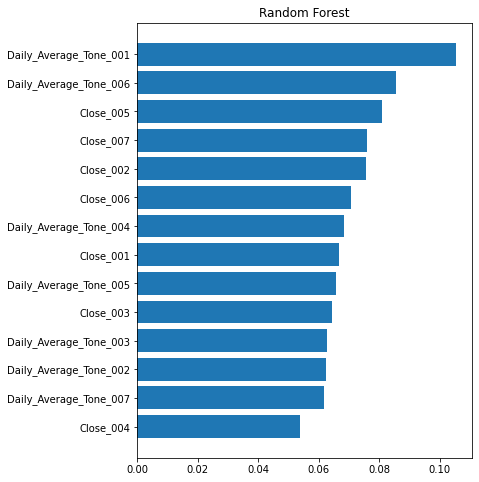

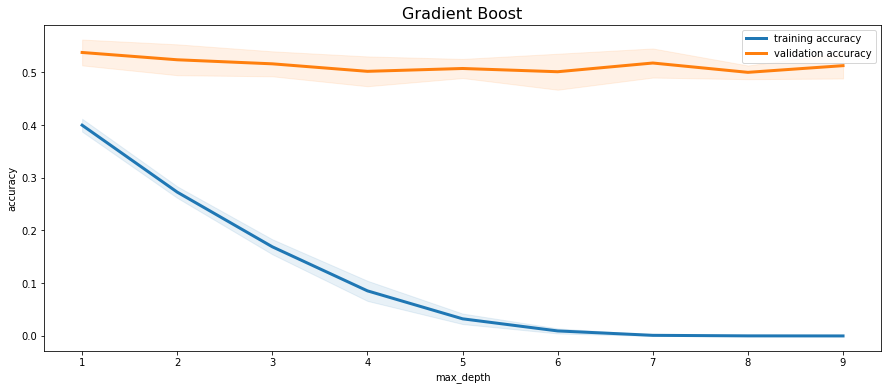

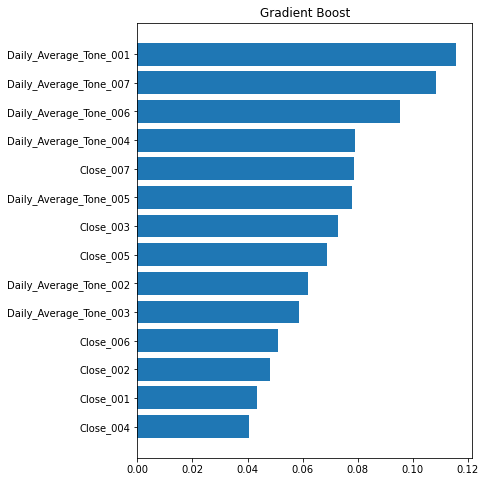

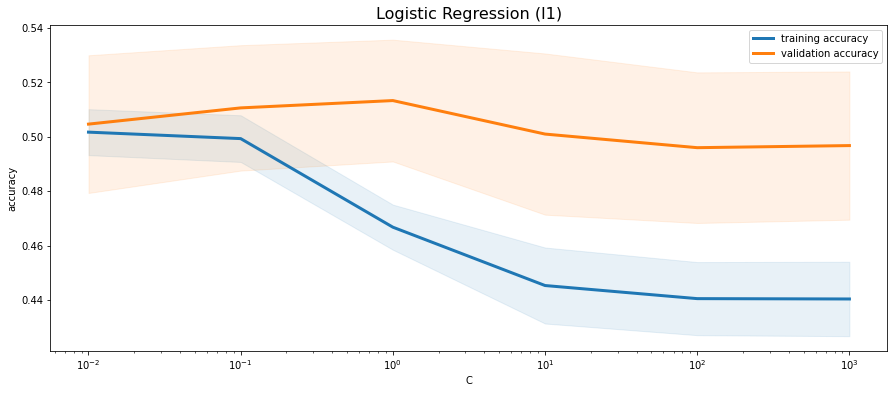

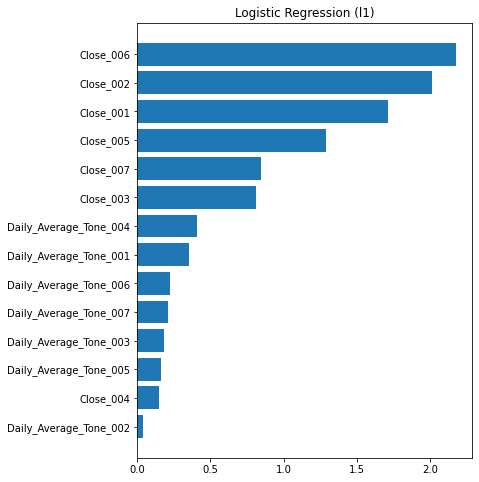

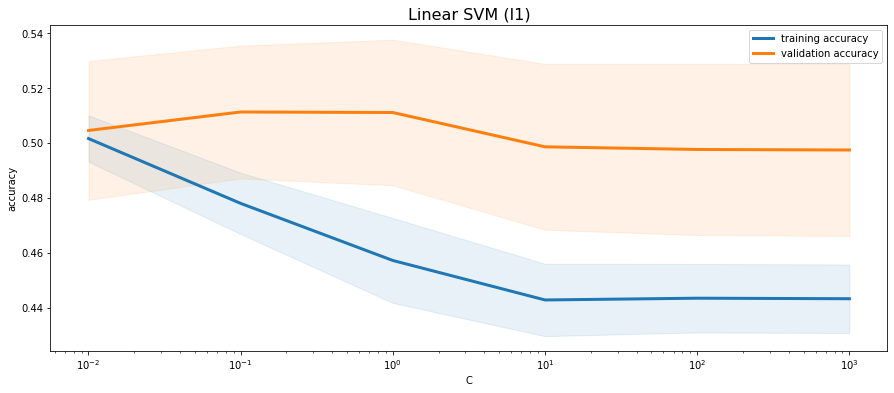

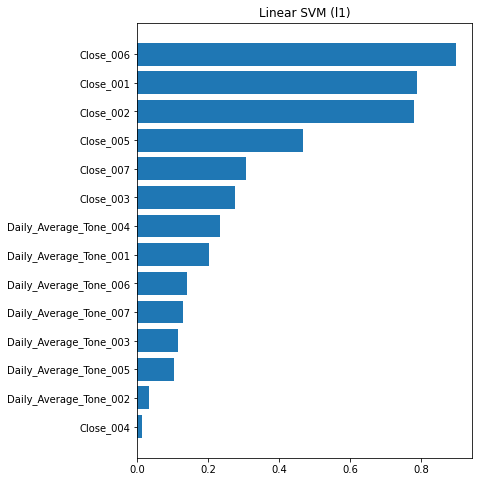

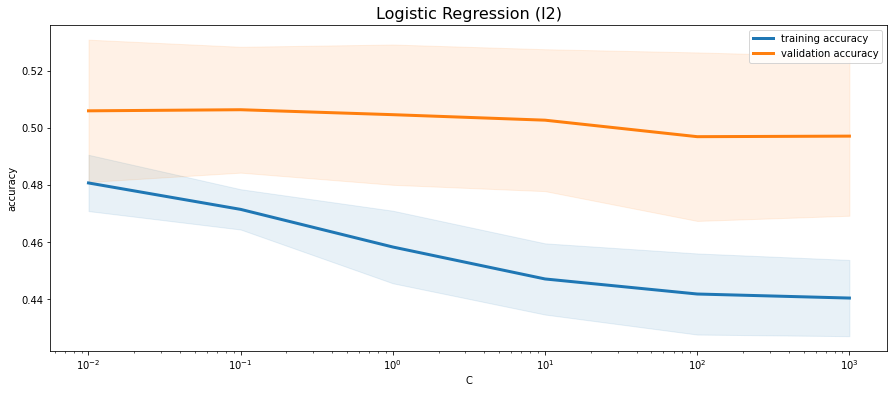

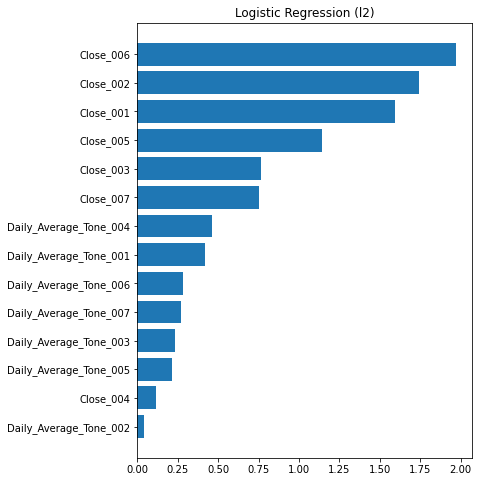

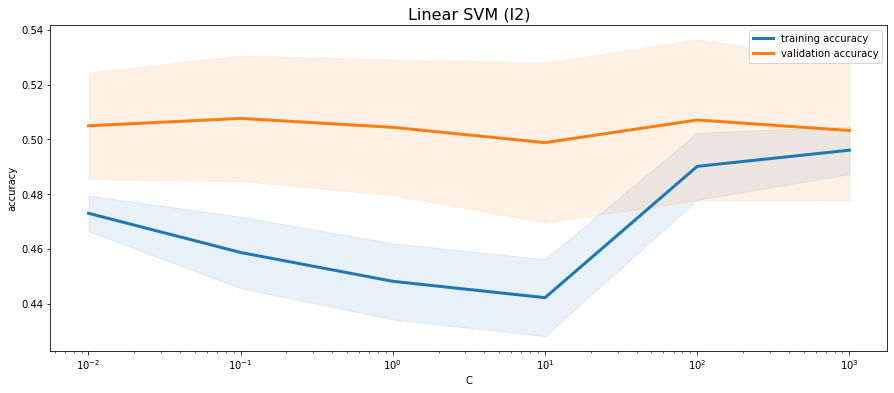

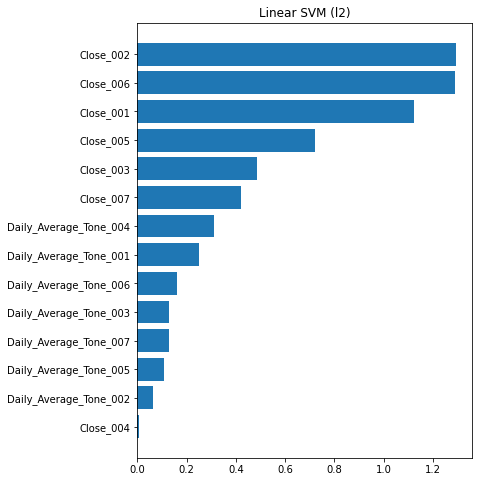

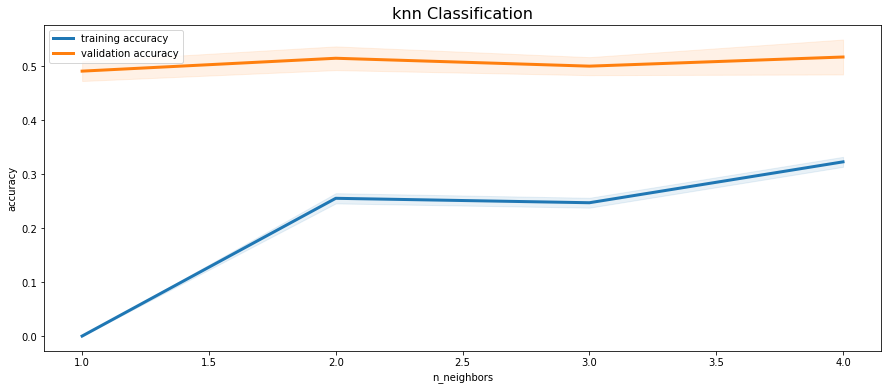

In [383]:
C = [.01, 0.1, 1, 10, 100, 1000]
n_neighbors = list(range(1, 51))
max_depth = list(range(1, 10))

automl_tree = AutoML(['dtc', 'rfc', 'gbc'])
splits = automl_tree.split_data(X, y, shuffle=True, num_trials=10, test_size=0.25)
automl_tree.train_model(X, y, param_grid={'max_depth':max_depth})
tree_summary = automl_tree.generate_summary()

automl_linear_l1 = AutoML(['log', 'svl'])
splits = automl_linear_l1.split_data(X, y, shuffle=True, num_trials=20, test_size=0.25)
automl_linear_l1.train_model(X, y, param_grid= {'C' : C}, 
                        fixed_params={'penalty' : 'l1'}, normalize=MinMaxScaler)
linearl1_summary = automl_linear_l1.generate_summary()

automl_linear_l2 = AutoML(['log', 'svl'])
splits = automl_linear_l2.split_data(X, y, shuffle=True, num_trials=20, test_size=0.25)
automl_linear_l2.train_model(X, y, param_grid= {'C' : C}, 
                        fixed_params={'penalty' : 'l2'}, normalize=MinMaxScaler)
linearl2_summary = automl_linear_l2.generate_summary()

automl_knc = AutoML('knc')
splits = automl_knc.split_data(X, y, num_trials=5, test_size=0.25, 
                               shuffle=True)
automl_knc.train_model(X, y, param_grid={'n_neighbors' : range(1,5)},
                               normalize=MinMaxScaler)
knc_summary = automl_knc.generate_summary()


df_train1 = pd.concat([tree_summary, 
                linearl1_summary, 
                linearl2_summary]).reset_index(drop=True)
knc_summary = pd.Series(knc_summary, index=df_train1.columns)
df_train1.loc[len(df_train1)] = knc_summary
df_train1

In [547]:
df_test = pd.DataFrame()
df_test['Close_000'] = df_full['Close']
# df_test['Daily_Average_Tone_000'] = df_full['Daily Average Tone']
df_test['MACD_000'] = df_full['MACD']
w = 7
h = 5
for lag in range(1,w+h):
    if len(str(lag)) < 3:
        pre_ = '0'*(3-len(str(lag)))
        lag_name = f'{pre_}{lag}'
    else:
        lag_name = str(lag)
    df_test[f'Close_{lag_name}'] = df_test['Close_000'].shift(lag)
#     df_test[f'Daily_Average_Tone_{lag_name}'] = df_test['Daily_Average_Tone_000'].shift(lag)
    df_test[f'MACD_{lag_name}'] = df_test['MACD_000'].shift(lag)
df_test = df_test.dropna()
display(df_test)

,Close_000,MACD_000,Close_001,MACD_001,Close_002,MACD_002,Close_003,MACD_003,Close_004,MACD_004,...,Close_007,MACD_007,Close_008,MACD_008,Close_009,MACD_009,Close_010,MACD_010,Close_011,MACD_011
11,40.125999,-0.485948,40.487999,-0.459364,39.911999,-0.455608,39.466000,-0.385541,40.667999,-0.245090,...,40.821999,-0.108865,41.467999,-0.019517,43.422001,0.029032,42.341999,-0.108378,40.891998,-0.172222
12,38.776001,-0.608931,40.125999,-0.485948,40.487999,-0.459364,39.911999,-0.455608,39.466000,-0.385541,...,40.751999,-0.183209,40.821999,-0.108865,41.467999,-0.019517,43.422001,0.029032,42.341999,-0.108378
13,38.175999,-0.746209,38.776001,-0.608931,40.125999,-0.485948,40.487999,-0.459364,39.911999,-0.455608,...,41.438000,-0.184645,40.751999,-0.183209,40.821999,-0.108865,41.467999,-0.019517,43.422001,0.029032
14,38.063999,-0.854194,38.175999,-0.746209,38.776001,-0.608931,40.125999,-0.485948,40.487999,-0.459364,...,40.667999,-0.245090,41.438000,-0.184645,40.751999,-0.183209,40.821999,-0.108865,41.467999,-0.019517
15,38.748001,-0.874499,38.063999,-0.854194,38.175999,-0.746209,38.776001,-0.608931,40.125999,-0.485948,...,39.466000,-0.385541,40.667999,-0.245090,41.438000,-0.184645,40.751999,-0.183209,40.821999,-0.108865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,55.212002,-0.755063,54.462002,-0.805355,54.639999,-0.781468,54.992001,-0.757736,53.556000,-0.752264,...,57.835999,-1.072413,55.972000,-1.395882,55.723999,-1.598652,54.966000,-1.808957,53.554001,-1.973892
1042,53.683998,-0.828947,55.212002,-0.755063,54.462002,-0.805355,54.639999,-0.781468,54.992001,-0.757736,...,57.175999,-0.859412,57.835999,-1.072413,55.972000,-1.395882,55.723999,-1.598652,54.966000,-1.808957
1043,53.540001,-0.888875,53.683998,-0.828947,55.212002,-0.755063,54.462002,-0.805355,54.639999,-0.781468,...,58.362000,-0.588127,57.175999,-0.859412,57.835999,-1.072413,55.972000,-1.395882,55.723999,-1.598652
1044,53.276001,-0.946756,53.540001,-0.888875,53.683998,-0.828947,55.212002,-0.755063,54.462002,-0.805355,...,53.556000,-0.752264,58.362000,-0.588127,57.175999,-0.859412,57.835999,-1.072413,55.972000,-1.395882


In [548]:
X = df_test.drop(['Close_000', 
#                   'Daily_Average_Tone_000', 
                  'MACD_000'], axis=1)
y = df_test.loc[:, 'Close_000']

In [549]:
X.columns

Index(['Close_001', 'MACD_001', 'Close_002', 'MACD_002', 'Close_003',
       'MACD_003', 'Close_004', 'MACD_004', 'Close_005', 'MACD_005',
       'Close_006', 'MACD_006', 'Close_007', 'MACD_007', 'Close_008',
       'MACD_008', 'Close_009', 'MACD_009', 'Close_010', 'MACD_010',
       'Close_011', 'MACD_011'],
      dtype='object')

knn Regression: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable,Run Time
0,Decision Tree,1.712060,max_depth = 4,Close_001,1.219588
1,Random Forest,1.663165,max_depth = 4,Close_001,23.144708
2,GradientBoost,1.650307,max_depth = 2,Close_001,41.531525
3,Lasso Regression,1.141809,alpha = 0.1,Close_001,0.317529
4,Ridge Regression,1.156197,alpha = 0.1,Close_001,0.697485
5,knn Regression,1.138122,n_neighbors = 2,NA,2.733472


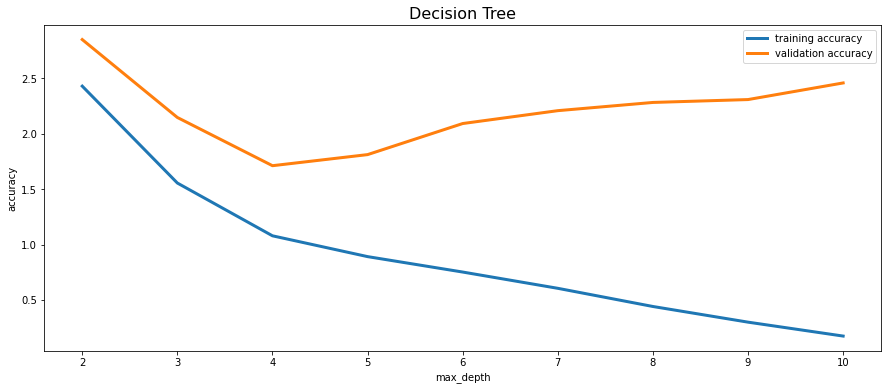

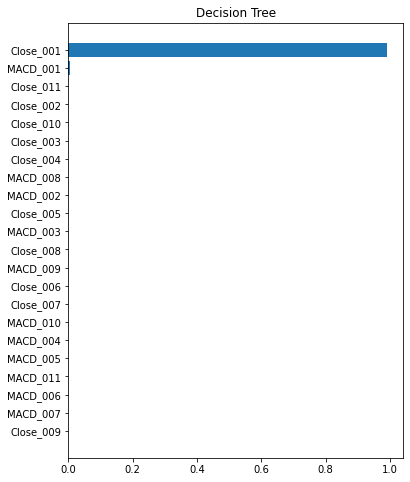

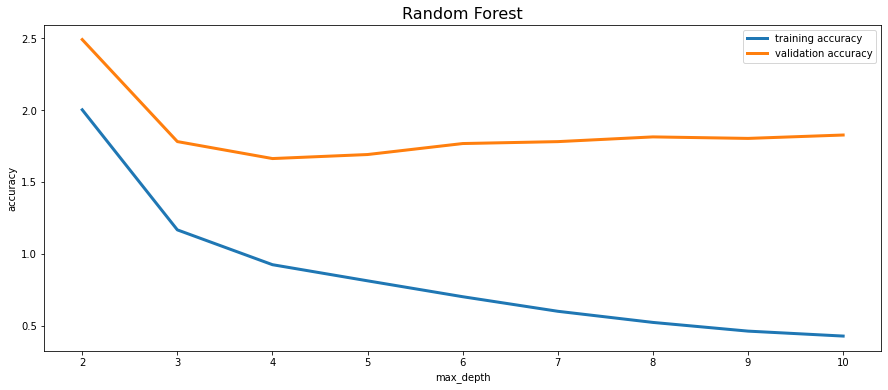

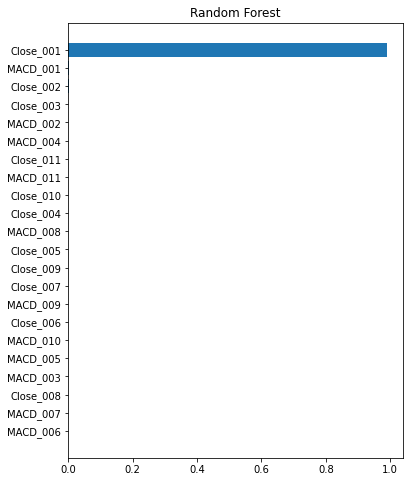

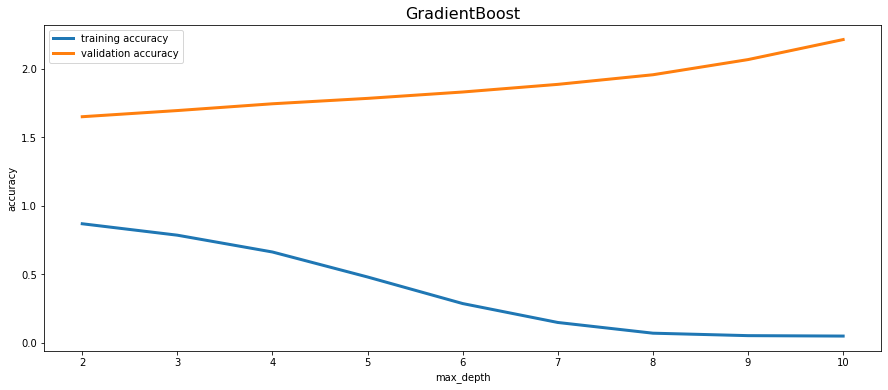

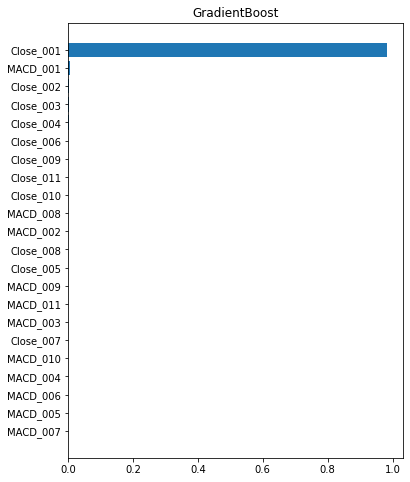

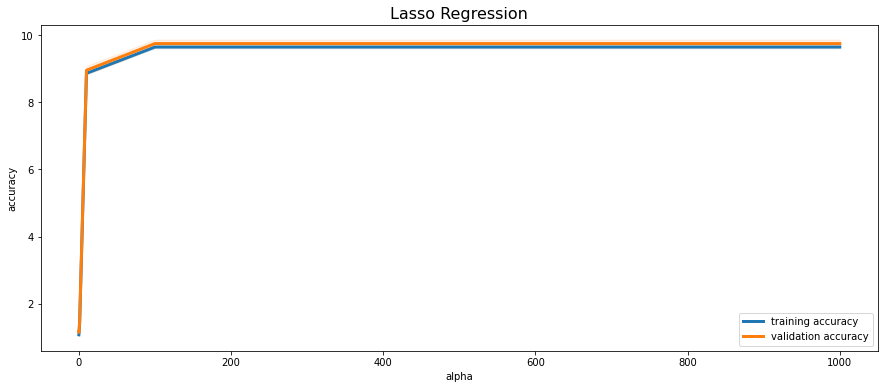

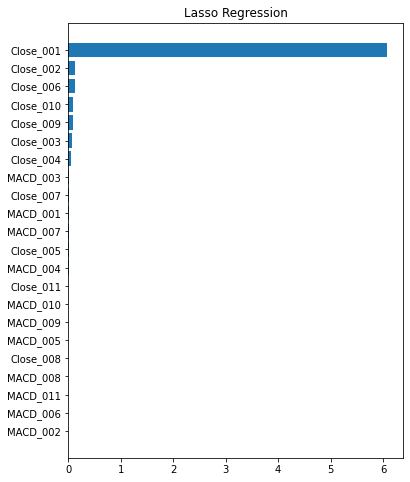

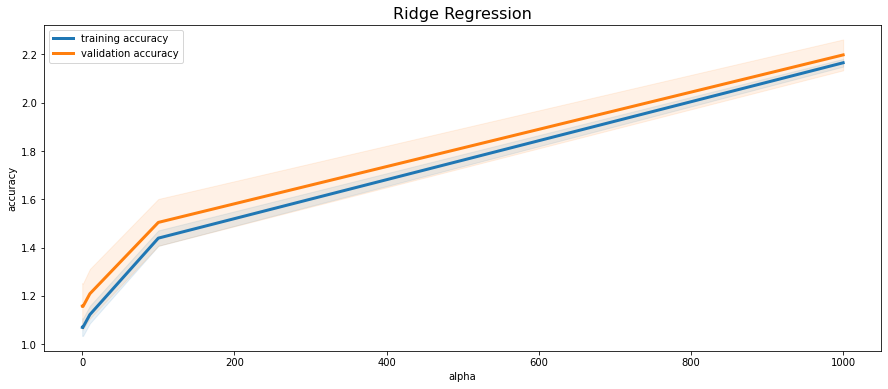

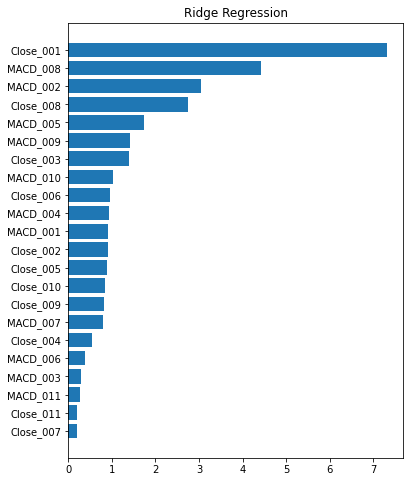

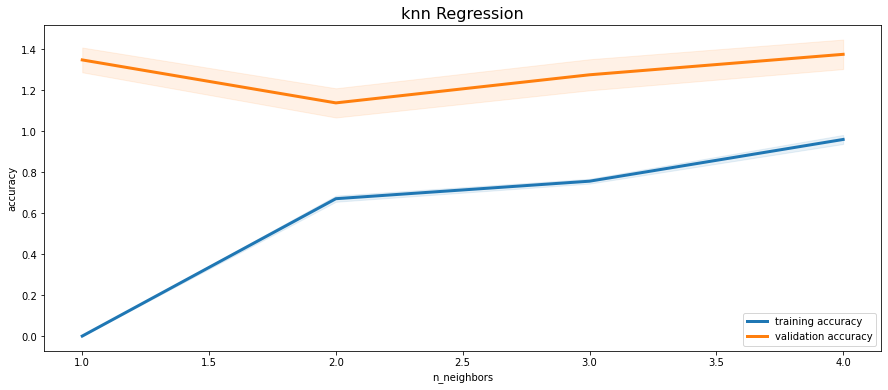

In [520]:
alpha = [1e-3, .01, 0.1,  1,  10, 100, 1000]
n_neighbors = list(range(1,50))
max_depth = list(range(1,10))

automl_tree = AutoML(['dtr', 'rfr', 'gbr'])
splits = automl_tree.split_data(X, y, shuffle=False, num_trials=10)
automl_tree.train_model(X, y)
tree_summary = automl_tree.generate_summary()

automl_linear = AutoML(['lso', 'rdg'])
splits = automl_linear.split_data(X, y, num_trials=5, test_size=0.25, 
                               shuffle=True)
automl_linear.train_model(X, y, param_grid={'alpha' : alpha},
                               normalize=StandardScaler)
linear_summary = automl_linear.generate_summary()

automl_knr = AutoML('knr')
splits = automl_knr.split_data(X, y, num_trials=5, test_size=0.25, 
                               shuffle=True)
automl_knr.train_model(X, y, param_grid={'n_neighbors' : range(1,5)},
                       normalize=StandardScaler)
knr_summary = automl_knr.generate_summary()


df = pd.concat([tree_summary, 
                linear_summary]).reset_index(drop=True)
knr_summary = pd.Series(knr_summary, index=df.columns)
df.loc[len(df)] = knr_summary
df

In [573]:
df_test = pd.DataFrame()
df_test['Close_000'] = df_full['Close']
# df_test['Daily_Average_Tone_000'] = df_full['Daily Average Tone']
df_test['MACD_000'] = df_full['MACD']
w = 7
h = 1
for lag in range(1,w+h):
    if len(str(lag)) < 3:
        pre_ = '0'*(3-len(str(lag)))
        lag_name = f'{pre_}{lag}'
    else:
        lag_name = str(lag)
    df_test[f'Close_{lag_name}'] = df_test['Close_000'].shift(lag)
#     df_test[f'Daily_Average_Tone_{lag_name}'] = df_test['Daily_Average_Tone_000'].shift(lag)
    df_test[f'MACD_{lag_name}'] = df_test['MACD_000'].shift(lag)
df_test = df_test.dropna()
display(df_test)

,Close_000,MACD_000,Close_001,MACD_001,Close_002,MACD_002,Close_003,MACD_003,Close_004,MACD_004,Close_005,MACD_005,Close_006,MACD_006,Close_007,MACD_007
7,40.667999,-0.245090,41.438000,-0.184645,40.751999,-0.183209,40.821999,-0.108865,41.467999,-0.019517,43.422001,0.029032,42.341999,-0.108378,40.891998,-0.172222
8,39.466000,-0.385541,40.667999,-0.245090,41.438000,-0.184645,40.751999,-0.183209,40.821999,-0.108865,41.467999,-0.019517,43.422001,0.029032,42.341999,-0.108378
9,39.911999,-0.455608,39.466000,-0.385541,40.667999,-0.245090,41.438000,-0.184645,40.751999,-0.183209,40.821999,-0.108865,41.467999,-0.019517,43.422001,0.029032
10,40.487999,-0.459364,39.911999,-0.455608,39.466000,-0.385541,40.667999,-0.245090,41.438000,-0.184645,40.751999,-0.183209,40.821999,-0.108865,41.467999,-0.019517
11,40.125999,-0.485948,40.487999,-0.459364,39.911999,-0.455608,39.466000,-0.385541,40.667999,-0.245090,41.438000,-0.184645,40.751999,-0.183209,40.821999,-0.108865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,55.212002,-0.755063,54.462002,-0.805355,54.639999,-0.781468,54.992001,-0.757736,53.556000,-0.752264,58.362000,-0.588127,57.175999,-0.859412,57.835999,-1.072413
1042,53.683998,-0.828947,55.212002,-0.755063,54.462002,-0.805355,54.639999,-0.781468,54.992001,-0.757736,53.556000,-0.752264,58.362000,-0.588127,57.175999,-0.859412
1043,53.540001,-0.888875,53.683998,-0.828947,55.212002,-0.755063,54.462002,-0.805355,54.639999,-0.781468,54.992001,-0.757736,53.556000,-0.752264,58.362000,-0.588127
1044,53.276001,-0.946756,53.540001,-0.888875,53.683998,-0.828947,55.212002,-0.755063,54.462002,-0.805355,54.639999,-0.781468,54.992001,-0.757736,53.556000,-0.752264


In [574]:
X = df_test.iloc[:,2:].copy()
y = df_test.loc[:, 'Close_000'].copy()

In [575]:
X

,Close_001,MACD_001,Close_002,MACD_002,Close_003,MACD_003,Close_004,MACD_004,Close_005,MACD_005,Close_006,MACD_006,Close_007,MACD_007
7,41.438000,-0.184645,40.751999,-0.183209,40.821999,-0.108865,41.467999,-0.019517,43.422001,0.029032,42.341999,-0.108378,40.891998,-0.172222
8,40.667999,-0.245090,41.438000,-0.184645,40.751999,-0.183209,40.821999,-0.108865,41.467999,-0.019517,43.422001,0.029032,42.341999,-0.108378
9,39.466000,-0.385541,40.667999,-0.245090,41.438000,-0.184645,40.751999,-0.183209,40.821999,-0.108865,41.467999,-0.019517,43.422001,0.029032
10,39.911999,-0.455608,39.466000,-0.385541,40.667999,-0.245090,41.438000,-0.184645,40.751999,-0.183209,40.821999,-0.108865,41.467999,-0.019517
11,40.487999,-0.459364,39.911999,-0.455608,39.466000,-0.385541,40.667999,-0.245090,41.438000,-0.184645,40.751999,-0.183209,40.821999,-0.108865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,54.462002,-0.805355,54.639999,-0.781468,54.992001,-0.757736,53.556000,-0.752264,58.362000,-0.588127,57.175999,-0.859412,57.835999,-1.072413
1042,55.212002,-0.755063,54.462002,-0.805355,54.639999,-0.781468,54.992001,-0.757736,53.556000,-0.752264,58.362000,-0.588127,57.175999,-0.859412
1043,53.683998,-0.828947,55.212002,-0.755063,54.462002,-0.805355,54.639999,-0.781468,54.992001,-0.757736,53.556000,-0.752264,58.362000,-0.588127
1044,53.540001,-0.888875,53.683998,-0.828947,55.212002,-0.755063,54.462002,-0.805355,54.639999,-0.781468,54.992001,-0.757736,53.556000,-0.752264


In [576]:
X.columns

Index(['Close_001', 'MACD_001', 'Close_002', 'MACD_002', 'Close_003',
       'MACD_003', 'Close_004', 'MACD_004', 'Close_005', 'MACD_005',
       'Close_006', 'MACD_006', 'Close_007', 'MACD_007'],
      dtype='object')

knn Regression: 100%|██████████| 5/5 [00:00<00:00, 20.35it/s]


,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable,Run Time
0,Decision Tree,1.710270,max_depth = 4,Close_001,0.919614
1,Random Forest,1.659703,max_depth = 4,Close_001,22.149558
2,GradientBoost,1.651688,max_depth = 2,Close_001,28.642763
3,Lasso Regression,1.117350,alpha = 0.1,Close_001,0.264251
4,Ridge Regression,1.124404,alpha = 100,MACD_002,1.700607
5,knn Regression,1.247294,n_neighbors = 2,NA,0.248879


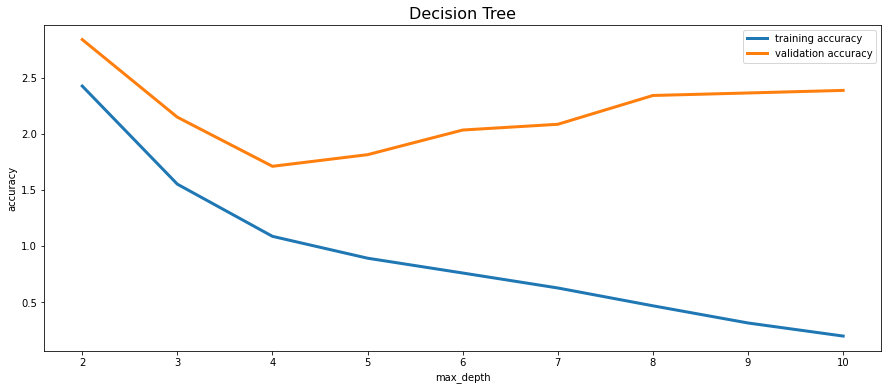

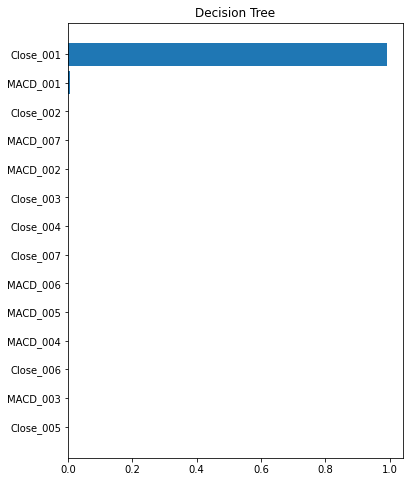

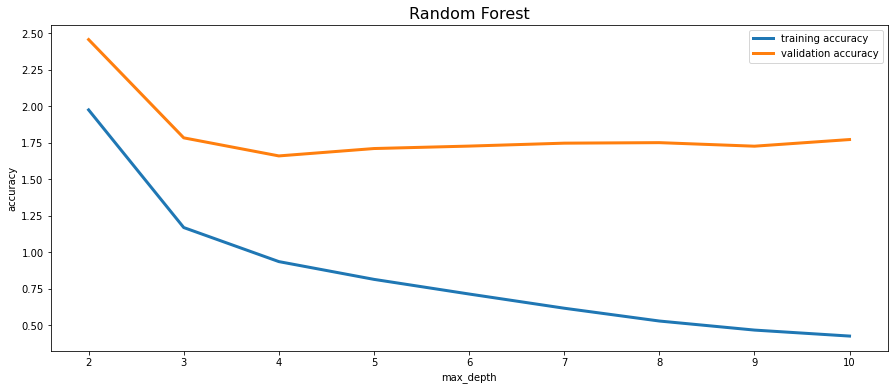

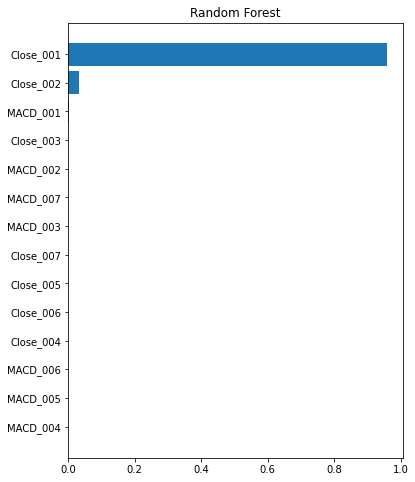

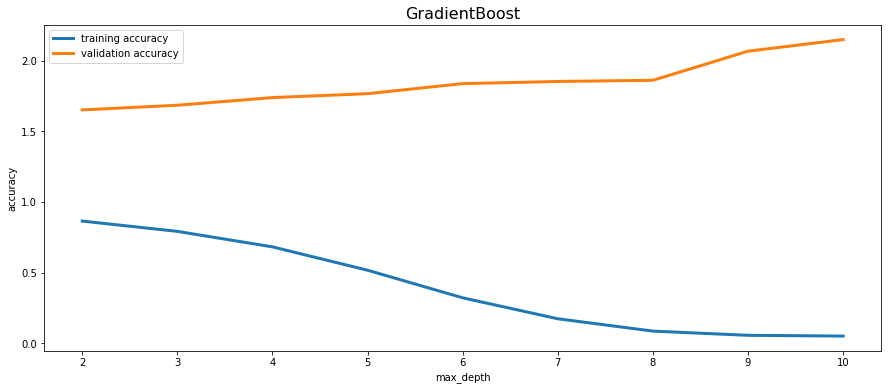

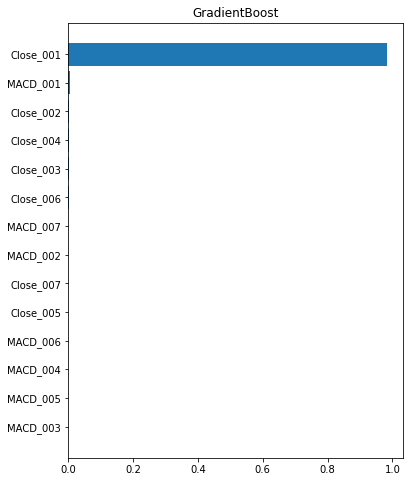

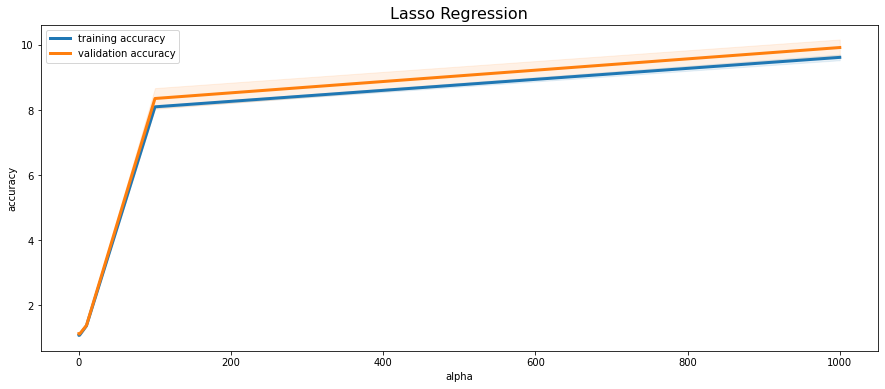

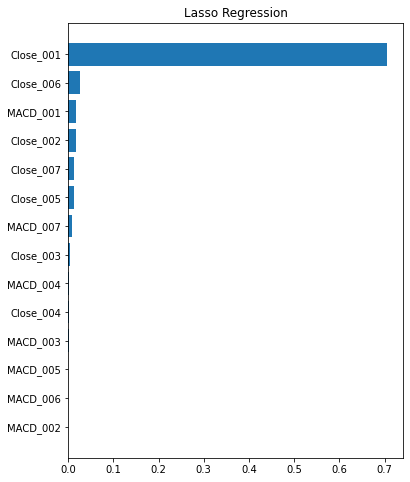

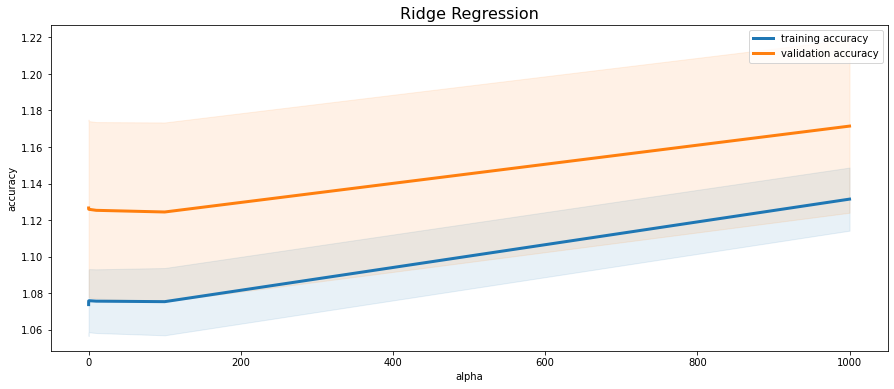

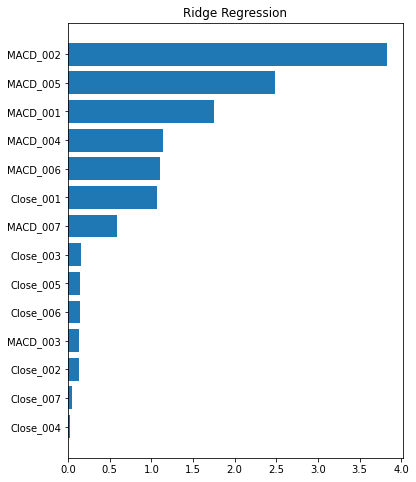

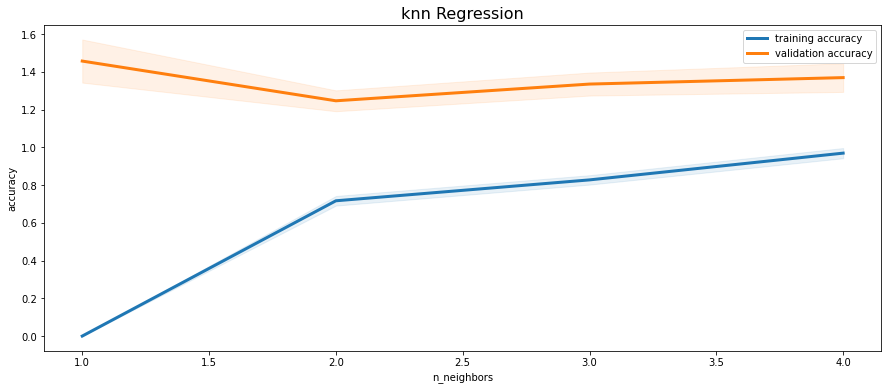

In [577]:
alpha = [1e-3, .01, 0.1,  1,  10, 100, 1000]
n_neighbors = list(range(1,50))
max_depth = list(range(1,10))

automl_tree = AutoML(['dtr', 'rfr', 'gbr'])
splits = automl_tree.split_data(X, y, shuffle=False, num_trials=10)
automl_tree.train_model(X, y)
tree_summary = automl_tree.generate_summary()

automl_linear = AutoML(['lso', 'rdg'])
splits = automl_linear.split_data(X, y, num_trials=5, test_size=0.25, 
                               shuffle=True)
automl_linear.train_model(X, y, param_grid={'alpha' : alpha},
                               )
linear_summary = automl_linear.generate_summary()

automl_knr = AutoML('knr')
splits = automl_knr.split_data(X, y, num_trials=5, test_size=0.25, 
                               shuffle=True)
automl_knr.train_model(X, y, param_grid={'n_neighbors' : range(1,5)},
                       normalize=StandardScaler)
knr_summary = automl_knr.generate_summary()


df = pd.concat([tree_summary, 
                linear_summary]).reset_index(drop=True)
knr_summary = pd.Series(knr_summary, index=df.columns)
df.loc[len(df)] = knr_summary
df

knn Regression: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable,Run Time
0,Decision Tree,2.960691,max_depth = 4,Close_003,1.437470
1,Random Forest,2.831560,max_depth = 4,Close_003,24.188604
2,GradientBoost,2.759509,max_depth = 2,Close_003,51.792478
3,Lasso Regression,2.004278,alpha = 1,Close_003,0.747881
4,Ridge Regression,2.029192,alpha = 100,MACD_011,1.794368
5,knn Regression,2.511907,n_neighbors = 4,NA,7.730829


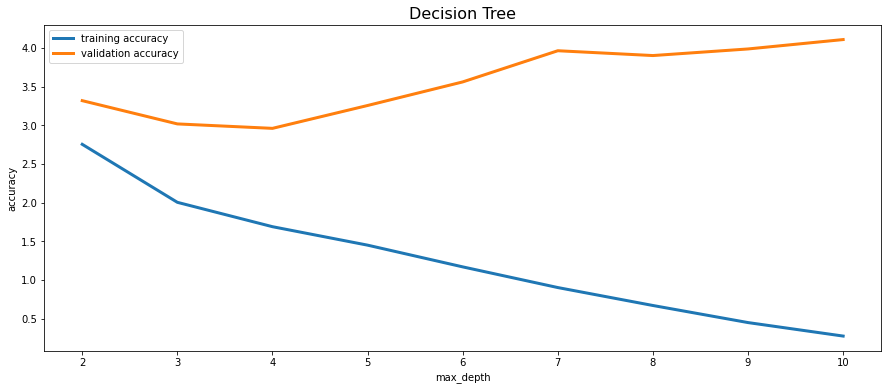

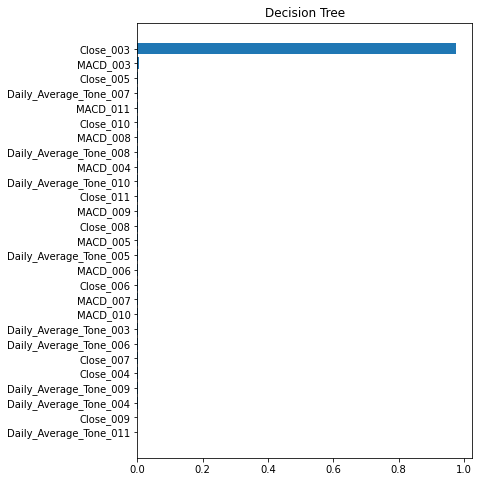

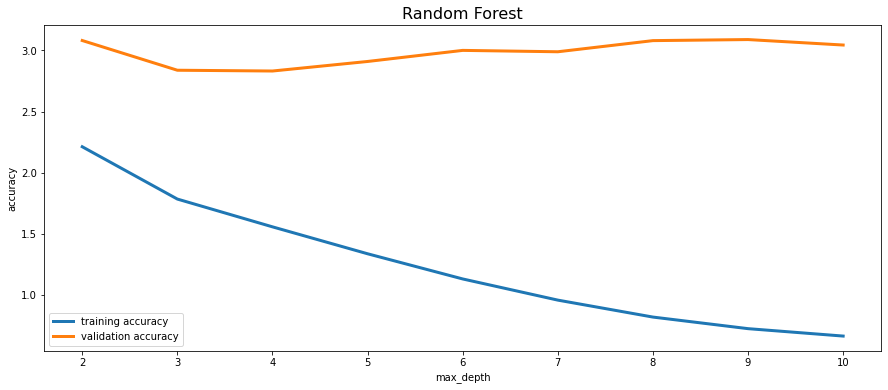

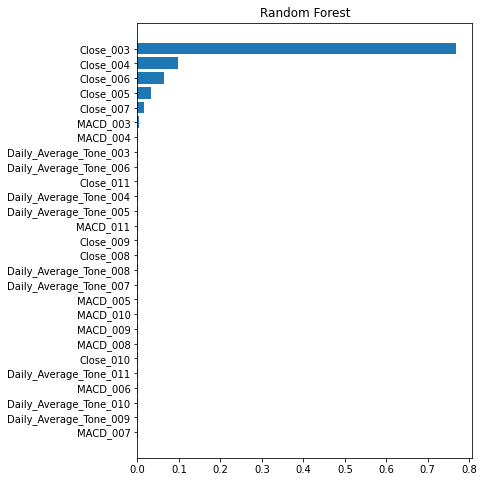

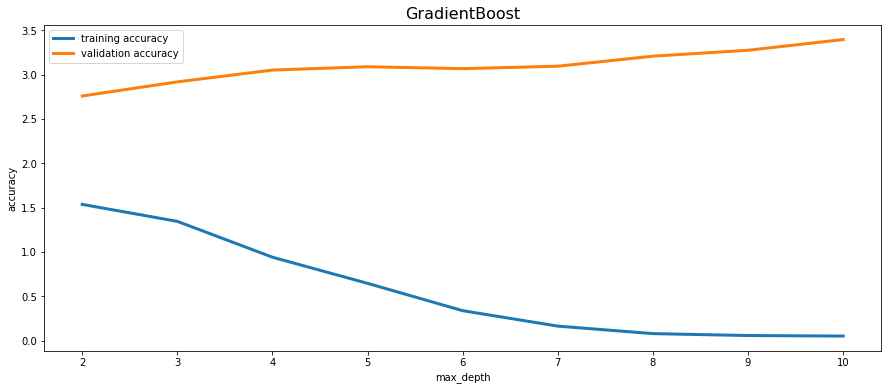

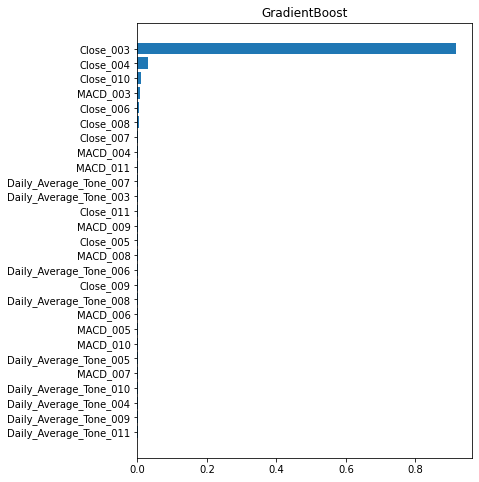

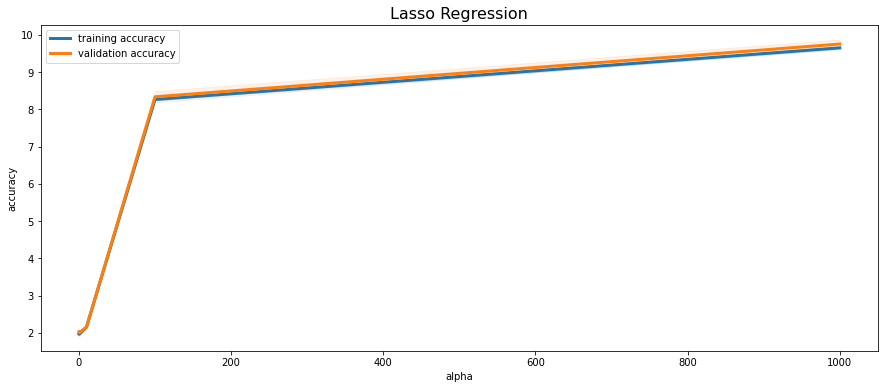

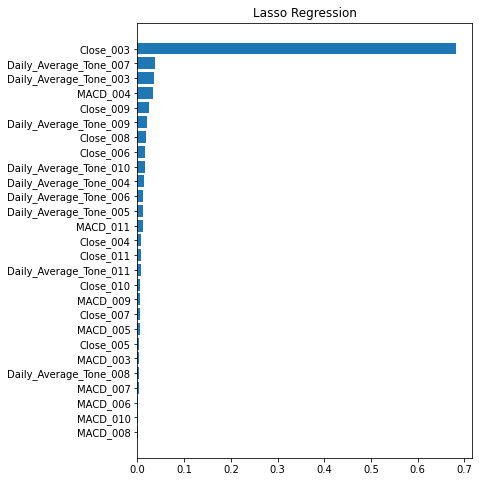

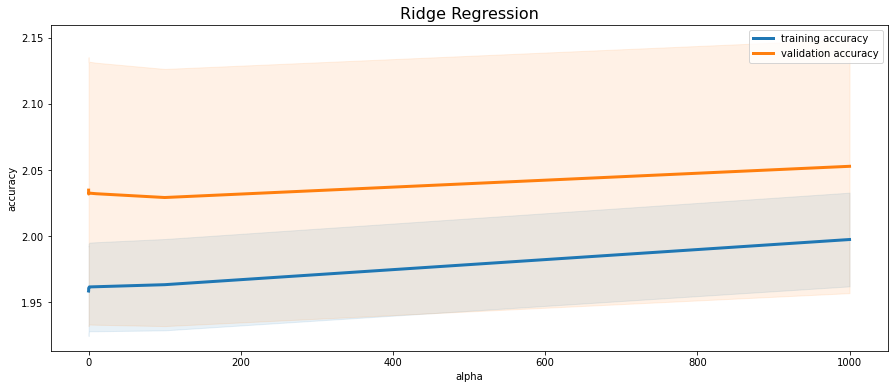

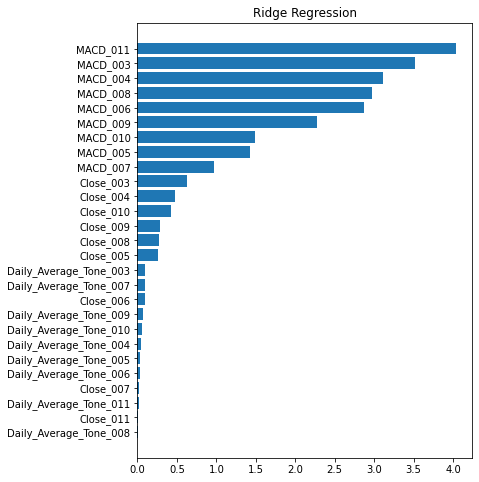

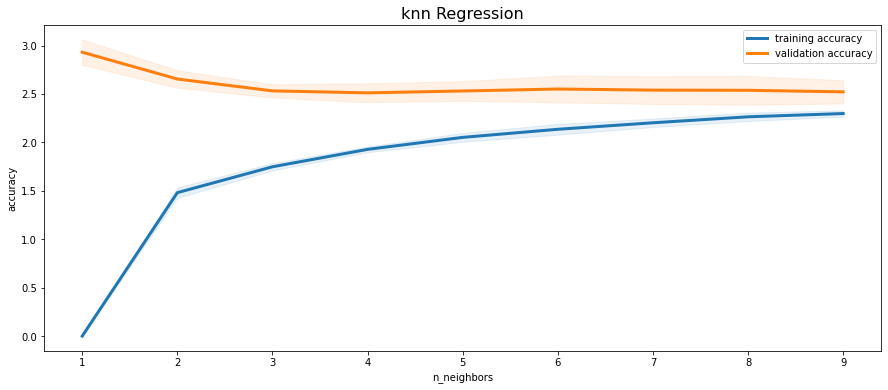

In [404]:
alpha = [1e-3, .01, 0.1,  1,  10, 100, 1000]
n_neighbors = list(range(1,50))
max_depth = list(range(1,10))

automl_tree = AutoML(['dtr', 'rfr', 'gbr'])
splits = automl_tree.split_data(X, y, shuffle=False, num_trials=10)
automl_tree.train_model(X, y)
tree_summary = automl_tree.generate_summary()

automl_linear = AutoML(['lso', 'rdg'])
splits = automl_linear.split_data(X, y, num_trials=5, test_size=0.25, 
                               shuffle=True)
automl_linear.train_model(X, y, param_grid={'alpha' : alpha},
                               )
linear_summary = automl_linear.generate_summary()

automl_knr = AutoML('knr')
splits = automl_knr.split_data(X, y, num_trials=5, test_size=0.25, 
                               shuffle=True)
automl_knr.train_model(X, y, param_grid={'n_neighbors' : range(1,10)},
                       normalize=StandardScaler)
knr_summary = automl_knr.generate_summary()


df = pd.concat([tree_summary, 
                linear_summary]).reset_index(drop=True)
knr_summary = pd.Series(knr_summary, index=df.columns)
df.loc[len(df)] = knr_summary
df

In [405]:
X = df_test.iloc[:,9:].copy()
y = df_test.loc[:, 'Close_000'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [408]:
model = Lasso(alpha=1)
model.fit(X_train, y_train)

y_predict = model.predict(X_test)
mean_absolute_error(y_test, y_predict)

2.707023760497168

In [409]:
y_predict

array([69.07518268, 68.57617772, 69.63305848, 69.94528605, 70.17787067,
       68.88098065, 67.30389578, 68.31030421, 69.57102633, 68.83989764,
       70.47062096, 69.51151685, 68.4550263 , 66.454342  , 66.59682662,
       68.70161946, 62.97102911, 62.04679884, 63.08092446, 64.51689472,
       64.25800858, 66.48835767, 66.77637861, 66.64100628, 66.40132362,
       68.86592748, 70.00238591, 71.02732609, 69.83184107, 68.3292401 ,
       66.03816635, 66.82879758, 66.47445203, 65.44832581, 66.23517608,
       65.60415329, 65.22551432, 68.74353092, 68.02665746, 65.11612215,
       64.96599708, 64.14055617, 62.62930388, 62.04638543, 63.16126465,
       61.71711092, 60.25757534, 60.7702034 , 55.96334463, 51.85518928,
       53.45143305, 50.76231022, 53.58561039, 57.29338753, 60.82407304,
       59.64693299, 57.84052129, 60.78700964, 60.07032511, 58.75477858,
       59.98653921, 58.21835226, 57.54328819, 58.63907957, 59.89358323,
       58.00851037, 56.69929995, 56.73104568, 56.18045034, 57.08

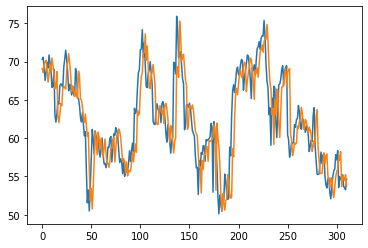

In [521]:
plt.plot(y_test.to_numpy())
plt.plot(y_predict)